In [1]:
"""
Created on Tue Ago 03 15:14:57 2021

@author: WilL
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pysal
import os
from shapely.ops import cascaded_union
from geovoronoi import voronoi_regions_from_coords
from geovoronoi import points_to_coords
from shapely.geometry import Point, LineString, Polygon
# from geovoronoi import voronoi_regions_from_coords
from pysal.explore import esda
from pysal.lib import weights
from matplotlib import colors
import plotly.graph_objs as go
import chart_studio.plotly as py
import shapely
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import shap
from joblib import dump,load
from sklearn.metrics import confusion_matrix

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
# pip list

# script modo Ejecucion

In [3]:
modo_ejecucion='predicion' #  predicion / entrenamiento

In [4]:
####Definición de rutas#####
#os.chdir('D:\CLARO\GEOESPACIAL')  C:\\Users\WilsonAdolfoEstacioR\\Documents\
# os.chdir('D:\Gestion\Proyectos\GeoEspacial')
os.chdir('D:\\Will_Analisis\\')
analysis_dir = os.getcwd()
analisis_dir = os.getcwd()
data_cob_mayo=os.path.join(analisis_dir, 'Datos\\Shapefiles\\COBERTURAS_UNIFICADAS\\')
data_geojson = os.path.join(analisis_dir, 'Expansion_Fija\\Insumos\\Shapefiles') # C:\Users\WilsonAdolfoEstacioR\Documents\Expansion_Fija\Insumos\Shapefiles
data_dir= os.path.join(analisis_dir,'Expansion_Fija\\1_Datos\\') #\\Camacol
# C:\Users\WilsonAdolfoEstacioR\Documents\Expansion_Fija\1_Datos\INFO_NUEVA
result_dir= os.path.join(analisis_dir,'Expansion_Fija\\3_Resultados\\') # C:\Users\WilsonAdolfoEstacioR\Documents\Expansion_Fija\3_Resultados
# data_dir = os.path.join(analysis_dir, 'Expansion_Fija\1_Datos')
# result_dir = os.path.join(analysis_dir, 'Expansion_Fija\\3_Resultados')

In [5]:
# 	GID	DPTO_CCDGO	MPIO_CCDGO	MPIO_CNMBR	MPIO_CCNCT	DPTO_CNMBR	DTH_MPIO	NODO	FTTH_NODO	geometry
# categori_columna_x=HFC.Tipo.unique()
# categori_columna_x

In [6]:
####Lectura de datos####
HFC1=gpd.read_file(os.path.join(data_cob_mayo, "MAYO\\COBERTURA_UNIF_MAYO.shp"))
# HFC=gpd.read_file(os.path.join(analysis_dir, "Insumos\\Shapefiles\\COBERTURA_UNIF_MARZO.shp"))
# HFC=gpd.read_file(os.path.join(analysis_dir, "Insumos\\Shapefiles\\COBERTURA_UNIF_MARZO.shp"))
HFC1=HFC1.loc[HFC1.geometry.is_valid]
##HFC=HFC.drop_duplicates("NODO")
HFC1=HFC1.drop_duplicates("HFC_NODO")
HFC1=HFC1.reset_index(drop=True)
##Adicione esta instruccion para cambiar el nombre a la columna HFC_NODO
# HFC.rename(columns={'HFC_NODO':'NODO'},inplace=True)
HFC1.rename(columns={'mpio_ccnct':'MPIO_CCNCT'},inplace=True)
HFC1.rename(columns={'mpio_cnmbr':'MPIO_CNMBR'},inplace=True)
HFC1.rename(columns={'dpto_cnmbr':'DPTO_CNMBR'},inplace=True)
HFC1.rename(columns={'Tipo':'TIPO'},inplace=True)

In [7]:
HFC1.head(2)  # este toca cambiarlos alveniz    la antigua tenia  HFC_NODO, FTTH_NODO

,NODO,NOMBRE,TIPO,MPIO_CNMBR,MPIO_CCNCT,DPTO_CNMBR,DTH_MPIO,HFC_NODO,FTTH_NODO,geometry
0,CLN,SAN CARLOS 2,HFC,ACACÍAS,50006,META,None,CLN,None,"POLYGON ((-73.75938 3.99053, -73.75938 3.99054..."
1,NNN,ANTONIO NARIÑO,HFC,ACACÍAS,50006,META,None,NNN,None,"POLYGON ((-73.75938 3.99053, -73.75938 3.99053..."


In [8]:
HFC=gpd.read_file(os.path.join(data_cob_mayo, "OCTUBRE\\COBERTURA_UNIF_OCTUBRE.shp"))
HFC=HFC.loc[HFC.geometry.is_valid]
# HFC=HFC.drop_duplicates("HFC_NODO")
HFC=HFC.reset_index(drop=True)

# HFC.rename(columns={'mpio_ccnct':'MPIO_CCNCT'},inplace=True)
HFC.rename(columns={'mpio_cnmbr':'MPIO_CNMBR'},inplace=True)
HFC.rename(columns={'dpto_cnmbr':'DPTO_CNMBR'},inplace=True)
HFC.rename(columns={'Tipo':'TIPO'},inplace=True)

HFC['HFC_NODO']=HFC[HFC['TIPO']=='HFC']['NODO']
HFC['FTTH_NODO']=HFC[HFC['TIPO']=='FTTH']['NODO']

HFC=HFC.drop_duplicates("HFC_NODO")

In [9]:
HFC.shape

(13759, 11)

In [10]:
HFC.head(2)

,NODO,TIPO,MPIO_CNMBR,DPTO_CNMBR,DIVISION,AREA,ZONA,DISTRITO,geometry,HFC_NODO,FTTH_NODO
0,LSU,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236564.189 560360.757, -8236558.51...",LSU,NaN
1,EDZ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236551.499 560363.104, -8236345.00...",EDZ,NaN


In [11]:
# para ver que tipo de variables tiene las columnas
categori_columna_x=HFC.TIPO.unique()
categori_columna_x

array(['HFC', 'FTTH'], dtype=object)

In [12]:
Dane=gpd.read_file((os.path.join(data_geojson, "MGN_DANE_SECT_URB_4326_Topo_V2.geojson")))

In [13]:
Dane.head(2) # puedo utilizar este mismo

,SETU_CCNCT,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,CLAS_CCDGO,SETR_CCDGO,SETR_CCNCT,SECR_CCDGO,SECR_CCNCT,ZU_CCDGO,...,E70_79,MAS_80,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,shape_id,geometry
0,050011000000000101,05,001,05001,1,000,050011000,00,05001100000,000,...,647.0,334.0,6884.0,2820.0,1451.0,0.0,803.0,363.0,-75.5442 | 6.29755,"MULTIPOLYGON (((-75.54263 6.30185, -75.54252 6..."
1,050011000000000102,05,001,05001,1,000,050011000,00,05001100000,000,...,180.0,94.0,2969.0,2522.0,454.0,0.0,381.0,133.0,-75.5393 | 6.29858,"MULTIPOLYGON (((-75.54038 6.30232, -75.54038 6..."


<AxesSubplot:>

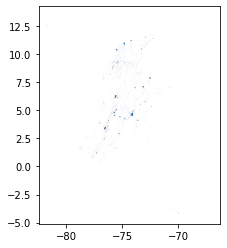

In [14]:
Dane.plot()

In [15]:
HFC.head(2)  # la antigua tenia  HFC_NODO, FTTH_NODO

,NODO,TIPO,MPIO_CNMBR,DPTO_CNMBR,DIVISION,AREA,ZONA,DISTRITO,geometry,HFC_NODO,FTTH_NODO
0,LSU,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236564.189 560360.757, -8236558.51...",LSU,NaN
1,EDZ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236551.499 560363.104, -8236345.00...",EDZ,NaN


<AxesSubplot:>

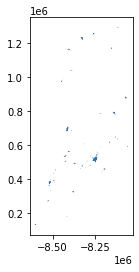

In [16]:
HFC.plot()

In [17]:
#Bases de proyectos nuevos - en curso
# camacol=pd.read_excel(os.path.join(data_dir, "Data_old\\Camacol\\Camacol.xlsx"), parse_dates=True)  # con la base anterior
camacol=pd.read_excel(os.path.join(data_dir, "Nuevos_datos\\dat_camacol.xlsx"), parse_dates=True)  # con la nueva base de datos
camacol['Fecha Terminación Construcción']=pd.to_datetime(camacol['Fecha Terminación Construcción'], errors="coerce")
camacol['Fecha De Entrega']=pd.to_datetime(camacol['Fecha De Entrega'], errors="coerce")
camacol['Fecha Inicio Construcción']=pd.to_datetime(camacol['Fecha Inicio Construcción'], errors="coerce")

In [18]:
pd.set_option('display.max_columns', None)
camacol.head(2)

,Unnamed: 0,Regional,Ciudad,Fecha Terminación Construcción,Fecha De Entrega,Nombre Del Proyecto,Direccion,Nombre de la Etapa,Uso de la Etapa,Unidades por Etapa,Nombre Del Constructor,Teléfono Del Constructor,Compañía Vendedora,Estado,Fase,Estrato,Barrio,Localidad,Longitud,Latitud,Usos,Id Proyecto,Segmento,Fecha Inicio Construcción,Unidades Por Tipo
0,0,Nariño,PASTO,2021-01-03,2022-01-07,RESERVA DE ALTAMIRA,CL 12 Sur #24 A -48,ETAPA1,Apartamento,128,CADINCO,7733304,CADINCO,Construcción,06 - Terminado,3,Ub. Villa De Los Rios,Comuna 6,-77.297223,1.201153,Vivienda,NaN,NaN,NaT,NaN
1,1,Nariño,PASTO,2022-01-07,2022-01-09,RESERVA DE ALTAMIRA,CL 12 Sur #24 A -48,ETAPA2,Apartamento,128,CADINCO,7733304,CADINCO,Construcción,04 - Obra Negra,3,Ub. Villa De Los Rios,Comuna 6,-77.297223,1.201153,Vivienda,NaN,NaN,NaT,NaN


In [19]:
Bogota_actual=pd.read_csv(os.path.join(data_dir, "Bogota202111.csv"))  #Datos Abiertos Bogotá (bogota.gov.co)  https://datosabiertos.bogota.gov.co/dataset/vivienda-nueva-bogota

In [20]:
Bogota_actual.head(2)  # se descarga de 

,id,Nombre,Dirección,Barrio,Localidad,Tipo,Unidades,Mes de reporte,Año de reporte,Telefono,Estrato,longitud,latitud
0,30712,Reserva de la Sierra,Cr. 7 # 126-30,Pinar de Santa Bárbara,Usaquén,No VIS,31,Enero,2021,3104476241,6,-74.026849,4.700923
1,30959,Oqyana,Tv. 19A # 96-56,Chicó,Chapinero,No VIS,1,Enero,2021,3164532356,6,-74.053723,4.684059


In [21]:
#Bogota_actual=Bogota_actual[['OBJECTID', 'id', 'Unidades', 'Tipo', 'latitud', 'longitud']]
Bogota_actual=Bogota_actual[['id', 'Unidades', 'Tipo', 'latitud', 'longitud']]
bogota_hitorico=gpd.read_file(os.path.join(data_dir, "Bogota_proyecto.geojson"))
bogota_hitorico=bogota_hitorico.to_crs("EPSG:4326")
bogota_hitorico['Tipo']="No_definido"
bogota_hitorico=bogota_hitorico[['objectid', 'id_proyect', 'fecha_actu','Tipo','geometry']].copy()

In [22]:
bogota_hitorico.sample(2)

,objectid,id_proyect,fecha_actu,Tipo,geometry
491,2117,31120,2021-05-20,No_definido,POINT (-74.04190 4.72060)
2574,1460,50649,2021-05-20,No_definido,POINT (-74.09590 4.67770)


In [23]:
#Data wrangling Ookla
# ookla1=pd.read_csv(os.path.join(data_dir,"INFO\\NUEVO_NODO_OOKLA_FIJA.csv"), sep=";")  # este ya lo tengo desde el 2020 lo genera cristian  # antiguo
ookla=pd.read_csv(os.path.join(data_dir,"Nuevos_datos\\N_NODO_OOKLA_FIJA.csv"), sep=",")  # este ya lo tengo desde el 2020 lo genera cristian
#ookla=pd.read_csv(os.path.join(data_dir,"INFO_NUEVA\\Ookla_row_data.csv"), sep=";")

In [24]:
ookla

,NODO,MES,ANIO,OPERADOR,latency_mediana,avg_latency,AVG_DOWNLOAD_MBPS,median_DOWNLOAD_MBPS,AVG_UPLOAD_MBPS,MEDIAN_UPLOAD_MBPS
0,ENC,9,2020,CLARO,11,13.071429,30.857143,18.0,5.214286,6.0
1,1B2013,1,2021,CLARO,12,11.800000,103.200000,85.0,7.200000,7.0
2,44A13D,7,2021,ETB,5,4.000000,114.142857,106.0,61.000000,56.0
3,BSC2,12,2020,MOVISTAR,27,27.000000,9.000000,9.0,1.000000,1.0
4,UT2,6,2021,CLARO,14,25.421053,62.684211,41.0,8.052632,8.0
...,...,...,...,...,...,...,...,...,...,...
557503,G8D,1,2021,MOVISTAR,7,7.000000,61.000000,61.0,75.500000,76.0
557504,1B8011,1,2021,ETB,4,3.714286,133.892857,140.0,77.964286,92.0
557505,MDR1,8,2020,MOVISTAR,27,27.000000,23.000000,23.0,23.000000,23.0
557506,5B0012,2,2021,ETB,4,9.611111,135.000000,141.0,61.777778,54.0


In [25]:
ookla.drop(columns = ['avg_latency','median_DOWNLOAD_MBPS','MEDIAN_UPLOAD_MBPS'], inplace = True)
ookla.rename(columns = {'AVG_DOWNLOAD_MBPS':'DOWNLOAD_MBPS', 
                          'AVG_UPLOAD_MBPS':'UPLOAD_MBPS', 
                          'latency_mediana':'LATENCY',
                         }, inplace = True)

In [26]:
ookla

,NODO,MES,ANIO,OPERADOR,LATENCY,DOWNLOAD_MBPS,UPLOAD_MBPS
0,ENC,9,2020,CLARO,11,30.857143,5.214286
1,1B2013,1,2021,CLARO,12,103.200000,7.200000
2,44A13D,7,2021,ETB,5,114.142857,61.000000
3,BSC2,12,2020,MOVISTAR,27,9.000000,1.000000
4,UT2,6,2021,CLARO,14,62.684211,8.052632
...,...,...,...,...,...,...,...
557503,G8D,1,2021,MOVISTAR,7,61.000000,75.500000
557504,1B8011,1,2021,ETB,4,133.892857,77.964286
557505,MDR1,8,2020,MOVISTAR,27,23.000000,23.000000
557506,5B0012,2,2021,ETB,4,135.000000,61.777778


In [27]:
ookla_pv=pd.pivot_table(ookla, index=['NODO', 'OPERADOR'],columns=['ANIO',"MES"], values="LATENCY", aggfunc={'LATENCY':'mean'})
ookla_pv20=ookla_pv[2020].add_prefix("2020_")
ookla_pv21=ookla_pv[2021].add_prefix("2021_")
ookla_total=ookla_pv20.merge(ookla_pv21, left_index=True, right_index=True, how="outer")
ookla_total_2=ookla_total.copy()

In [28]:
ookla_pv.head(2)

ANIO          2020                             2021                           \
MES             7     8     9     10    11  12   1     2     3     4      5    
NODO OPERADOR                                                                  
01J  CLARO     NaN  35.0  26.0  20.0  32.0 NaN  NaN  18.0  22.0  27.0    NaN   
     MOVISTAR  NaN  14.0   NaN  48.0   NaN NaN  NaN   NaN   8.0   NaN  118.0   

ANIO                                                    
MES              6     7     8     9     10    11   12  
NODO OPERADOR                                           
01J  CLARO     24.0  14.0  16.0  16.0  13.0  17.0  NaN  
     MOVISTAR   NaN   9.0   NaN  44.0   NaN   NaN  9.0

In [29]:
#Función para clasificar latencia
def gr_latencia(valor):
    if valor<=9.01:
        return 1
    else:
        return 2

In [30]:
##Aplicar la función y crear nuevos campos para almacenar esta información
for i in ookla_total.columns:
    name="Flag"+i
    ookla_total[name]=ookla_total[i].apply(lambda x: gr_latencia(x))

In [31]:
ookla_total.head(2)

MES            2020_7  2020_8  2020_9  2020_10  2020_11  2020_12  2021_1  \
NODO OPERADOR                                                              
01J  CLARO        NaN    35.0    26.0     20.0     32.0      NaN     NaN   
     MOVISTAR     NaN    14.0     NaN     48.0      NaN      NaN     NaN   

MES            2021_2  2021_3  2021_4  2021_5  2021_6  2021_7  2021_8  2021_9  \
NODO OPERADOR                                                                   
01J  CLARO       18.0    22.0    27.0     NaN    24.0    14.0    16.0    16.0   
     MOVISTAR     NaN     8.0     NaN   118.0     NaN     9.0     NaN    44.0   

MES            2021_10  2021_11  2021_12  Flag2020_7  Flag2020_8  Flag2020_9  \
NODO OPERADOR                                                                  
01J  CLARO        13.0     17.0      NaN           2           2           2   
     MOVISTAR      NaN      NaN      9.0           2           2           2   

MES            Flag2020_10  Flag2020_11  Flag2020_12  Flag2021_1  Flag2021_2  \
NODO OPERADOR                                                                  
01J  CLARO               2            2            2           2           2   
     MOVISTAR            2            2            2           2           2   

MES            Flag2021_3  Flag2021_4  Flag2021_5  Flag2021_6  Flag2021_7  \
NODO OPERADOR                                                               
01J  CLARO              2           2           2           2           2   
     MOVISTAR           1           2           2           2           1   

MES            Flag2021_8  Flag2021_9  Flag2021_10  Flag2021_11  Flag2021_12  
NODO OPERADOR                                                                 
01J  CLARO              2           2            2            2            2  
     MOVISTAR           2           2            2            2            1

In [32]:
##Seleccionar solo columnas flag
ookla_total_flag=ookla_total[[k for k in ookla_total.columns if 'Flag' in k]]
ookla_total_flag2=ookla_total_flag.copy()

In [33]:
ookla_total_flag2.head(2)

MES            Flag2020_7  Flag2020_8  Flag2020_9  Flag2020_10  Flag2020_11  \
NODO OPERADOR                                                                 
01J  CLARO              2           2           2            2            2   
     MOVISTAR           2           2           2            2            2   

MES            Flag2020_12  Flag2021_1  Flag2021_2  Flag2021_3  Flag2021_4  \
NODO OPERADOR                                                                
01J  CLARO               2           2           2           2           2   
     MOVISTAR            2           2           2           1           2   

MES            Flag2021_5  Flag2021_6  Flag2021_7  Flag2021_8  Flag2021_9  \
NODO OPERADOR                                                               
01J  CLARO              2           2           2           2           2   
     MOVISTAR           2           2           1           2           2   

MES            Flag2021_10  Flag2021_11  Flag2021_12  
NODO OPERADOR                                         
01J  CLARO               2            2            2  
     MOVISTAR            2            2            1

In [34]:
##Función de ajuste en la latencia, Sí un punto ya ha tenido fibra en meses anteriores se ajustan los siguientes meses
def latencia_st(actual, anterior):
    if actual==1:
        return 1
    else:
        if actual==2:
            if anterior==1:
                return 1
            else:
                return 2

In [35]:
for j in ookla_total_flag2.columns:
    if j=='Flag2020_7':####Cambiar al primer campo (Mes de la serie)
        j_ant = j
        continue
    else:
        ookla_total_flag2[j]=ookla_total_flag2.apply(lambda x:latencia_st(x[j], x[j_ant]),axis=1)
        j_ant = j

In [36]:
#Indeitifcar el mes de inicio FTH
def FTH_START(series):
    for k in ookla_total_flag2.columns:
        if series[k]==1:
            return k

In [37]:
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2.apply(lambda x: FTH_START(x),axis=1)
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2['Inicio_FTH'].apply(lambda x: x.replace("Flag", "") if pd.notnull(x) else np.nan )
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2['Inicio_FTH'].apply(lambda x: x.replace("_", "") if pd.notnull(x) else np.nan )
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2['Inicio_FTH'].apply(lambda x:np.nan if pd.isnull(x) else (x[0:4]+"0"+x[4] if len(x)==5 else x))

ookla_final=ookla_total_flag2.reset_index(level=[1])[['OPERADOR', 'Inicio_FTH']]
ookla_final['Inicio_FTH']=ookla_final['Inicio_FTH'].apply(lambda x: int(x) if pd.notnull(x) else 0)
nodos_ookla=pd.pivot_table(ookla_final, index=['NODO'], columns=['OPERADOR'], values="Inicio_FTH")
nodos_ookla.fillna(-1,inplace=True)##Marca para Nodos sin muestras
nodos_ookla=nodos_ookla.astype(int)

In [38]:
ookla_total_flag2.head(2)

MES            Flag2020_7  Flag2020_8  Flag2020_9  Flag2020_10  Flag2020_11  \
NODO OPERADOR                                                                 
01J  CLARO              2           2           2            2            2   
     MOVISTAR           2           2           2            2            2   

MES            Flag2020_12  Flag2021_1  Flag2021_2  Flag2021_3  Flag2021_4  \
NODO OPERADOR                                                                
01J  CLARO               2           2           2           2           2   
     MOVISTAR            2           2           2           1           1   

MES            Flag2021_5  Flag2021_6  Flag2021_7  Flag2021_8  Flag2021_9  \
NODO OPERADOR                                                               
01J  CLARO              2           2           2           2           2   
     MOVISTAR           1           1           1           1           1   

MES            Flag2021_10  Flag2021_11  Flag2021_12 Inicio_FTH  
NODO OPERADOR                                                    
01J  CLARO               2            2            2        NaN  
     MOVISTAR            1            1            1     202103

In [39]:
nodos_ookla.sample(2)

OPERADOR,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO
NODO,,,,,,
3B0011,202008,-1,-1,202009,202011,-1
36V,0,0,-1,0,0,0


In [40]:
# para encontrar informacion sobre la cantidad de nodos intervenidos a ultrawifi de cada operadr puso en cada año
categori_columna_x=nodos_ookla.TIGO.value_counts()
categori_columna_x

 0         6689
-1         2115
 202008     778
 202009     675
 202010     499
 202011     368
 202012     337
 202106     223
 202105     212
 202104     212
 202101     205
 202112     179
 202110     177
 202103     175
 202102     171
 202111     170
 202109     168
 202108     159
 202107     153
 202007       4
Name: TIGO, dtype: int64

In [41]:
nodos_ookla.to_csv(os.path.join(result_dir, "Inicion_ftth_NUEVO.csv"),encoding='utf-8')

In [42]:
# Unir capa de nodos
HFC2=HFC.merge(nodos_ookla, left_on="NODO", right_index=True, how="left")
#HFC2.to_file(os.path.join(data_dir, "HFC_Operador_vs.geojson"), driver='GeoJSON', encoding='utf-8')

In [43]:
HFC2.head(2)

,NODO,TIPO,MPIO_CNMBR,DPTO_CNMBR,DIVISION,AREA,ZONA,DISTRITO,geometry,HFC_NODO,FTTH_NODO,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO
0,LSU,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236564.189 560360.757, -8236558.51...",LSU,NaN,0.0,0.0,-1.0,0.0,202012.0,0.0
1,EDZ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236551.499 560363.104, -8236345.00...",EDZ,NaN,0.0,0.0,-1.0,202108.0,202009.0,0.0


In [44]:
########Definición del dato de límite de latencia#######
ookla_total_2['PROMEDIO_LATENCIA']=ookla_total_2.apply(lambda x: np.mean(x), axis=1)###Generar un promedio de la temporalidad

In [45]:
ookla_total_2.head(2)

MES            2020_7  2020_8  2020_9  2020_10  2020_11  2020_12  2021_1  \
NODO OPERADOR                                                              
01J  CLARO        NaN    35.0    26.0     20.0     32.0      NaN     NaN   
     MOVISTAR     NaN    14.0     NaN     48.0      NaN      NaN     NaN   

MES            2021_2  2021_3  2021_4  2021_5  2021_6  2021_7  2021_8  2021_9  \
NODO OPERADOR                                                                   
01J  CLARO       18.0    22.0    27.0     NaN    24.0    14.0    16.0    16.0   
     MOVISTAR     NaN     8.0     NaN   118.0     NaN     9.0     NaN    44.0   

MES            2021_10  2021_11  2021_12  PROMEDIO_LATENCIA  
NODO OPERADOR                                                
01J  CLARO        13.0     17.0      NaN          21.538462  
     MOVISTAR      NaN      NaN      9.0          35.714286

In [46]:
#Gráficos de distribución por operador
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['MOVISTAR'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("MOVISTAR")

In [47]:
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['ETB'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("ETB")

In [48]:
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['TIGO'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("TIGO")

In [49]:
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['CLARO'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("CLARO")

In [50]:
####Carga de capas de nodos y Zonas dane
Dane=Dane.to_crs("EPSG:3116") ## Proyección
HFC=HFC.to_crs("EPSG:3116")

In [51]:
Dane.crs

<Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - 75°35'W to 72°35'W
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [52]:
#Cálculo de área en kilometros
Dane['AREA_DANE']=Dane.geometry.area
HFC['AREA_HFC']=HFC.geometry.area

interseccion=gpd.overlay(Dane[['AREA_DANE', 'shape_id', 'geometry']], HFC[['NODO', 'AREA_HFC','geometry']])
interseccion['AREA_INT']=interseccion.geometry.area

In [53]:
#interseccion['RELACION_NODO']=interseccion['AREA_INT']/interseccion['AREA_DANE']
interseccion['RELACION_NODO']=interseccion['AREA_DANE']/interseccion['AREA_INT']

In [54]:
interseccion.head(2)

,AREA_DANE,shape_id,NODO,AREA_HFC,geometry,AREA_INT,RELACION_NODO
0,285400.802012,-75.549 | 6.28982,USE,45136.593221,"POLYGON ((836951.633 1187343.754, 836866.198 1...",1596.167681,178.803772
1,237253.992699,-75.5521 | 6.28742,USE,45136.593221,"POLYGON ((836868.180 1187373.122, 836866.198 1...",42823.465119,5.540280


In [55]:
DANE_NODO=Dane.merge(interseccion[[ 'shape_id', 'NODO', 'RELACION_NODO']], on="shape_id")
columnas_calculo=['ENCUESTAS', 'ENCUESTAS_ETNICO', 'ENCUESTAS_NO_ETNICO', 'ENCUESTAS_RESGUARDO', 'ENCUESTAS_COMUN_NEGRAS', 'ENCUESTAS_PROTEGIDAS',
                  'ENCUESTAS_NO_PROTEGIDAS', 'USO_VIVIENDA', 'USO_MIXTO','USO_RESIDENCIAL', 'USO_LEA', 'MIXTO_INDUSTRIA', 'MIXTO_COMERCIO', 'MIXTO_SERVICIOS',
                  'MIXTO_AGRO', 'MIXTO_SIN_INFO', 'INDUSTRIA', 'COMERCIO', 'SERVICIOS', 'AGROPECUARIO', 'INSTITUCIONAL', 'LOTE', 'PARQUE_ZONA_VERDE', 'MINERO',
                  'PROTECCION', 'CONSTRUCCION', 'SIN_INFORMACION', 'VIVIENDAS', 'CASA', 'APARTAMENTO', 'CUARTO',   'INDIGENA', 'ETNICA', 'OTRO',
                  'OCUPADA_PRESENTES', 'OCUPADA_AUSENTES', 'TEMPORAL', 'DESOCUPADA', 'HOGARES', 'ENERGIA_ELECTRICA', 'SIN_ENERGIA_ELECTRICA', 'ESTRATO1',
                  'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6', 'SIN_ESTRAT', 'ACUEDUCTO', 'SIN_ACUEDUCTO',  'ALCANTARILLADO', 'SIN_ALCANTARILLADO',
                  'GAS', 'SIN_GAS', 'GAS_SIN_INFORMACION', 'RECOLECCION_BASURAS', 'SIN_RECOLECCION','INTERNET', 'SIN_INTERNET', 'INTERNET_SIN_INFO', 'PERSONAS',
                  'PERSONAS_LEAS', 'HOGARES_PARTICULARES', 'HOMBRES', 'MUJERES', 'E0_9', 'E10_19', 'E20_29', 'E30_39', 'E40_49', 'E50_59', 'E60_69', 'E70_79',
                  'MAS_80', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION']

In [56]:
DANE_NODO.head(2)

,SETU_CCNCT,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,CLAS_CCDGO,SETR_CCDGO,SETR_CCNCT,SECR_CCDGO,SECR_CCNCT,ZU_CCDGO,ZU_CDIVI,SETU_CCDGO,VERSION,AREA,ENCUESTAS,ENCUESTAS_ETNICO,ENCUESTAS_NO_ETNICO,ENCUESTAS_RESGUARDO,ENCUESTAS_COMUN_NEGRAS,ENCUESTAS_PROTEGIDAS,ENCUESTAS_NO_PROTEGIDAS,USO_VIVIENDA,USO_MIXTO,USO_RESIDENCIAL,USO_LEA,MIXTO_INDUSTRIA,MIXTO_COMERCIO,MIXTO_SERVICIOS,MIXTO_AGRO,MIXTO_SIN_INFO,INDUSTRIA,COMERCIO,SERVICIOS,AGROPECUARIO,INSTITUCIONAL,LOTE,PARQUE_ZONA_VERDE,MINERO,PROTECCION,CONSTRUCCION,SIN_INFORMACION,VIVIENDAS,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,OCUPADA_PRESENTES,OCUPADA_AUSENTES,TEMPORAL,DESOCUPADA,HOGARES,ENERGIA_ELECTRICA,SIN_ENERGIA_ELECTRICA,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,SIN_ESTRAT,ACUEDUCTO,SIN_ACUEDUCTO,ALCANTARILLADO,SIN_ALCANTARILLADO,GAS,SIN_GAS,GAS_SIN_INFORMACION,RECOLECCION_BASURAS,SIN_RECOLECCION,INTERNET,SIN_INTERNET,INTERNET_SIN_INFO,PERSONAS,PERSONAS_LEAS,HOGARES_PARTICULARES,HOMBRES,MUJERES,E0_9,E10_19,E20_29,E30_39,E40_49,E50_59,E60_69,E70_79,MAS_80,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,shape_id,geometry,AREA_DANE,NODO,RELACION_NODO
0,050011000000000105,05,001,05001,1,000,050011000,00,05001100000,000,05001000,0105,10090.0,197990.979004,5314.0,0.0,5314.0,0.0,0.0,0.0,5314.0,5170.0,56.0,88.0,0.0,7.0,43.0,6.0,0.0,0.0,1.0,56.0,9.0,0.0,2.0,10.0,5.0,0.0,0.0,5.0,0.0,5226.0,3211.0,1812.0,202.0,0.0,0.0,1.0,4962.0,129.0,6.0,129.0,5238.0,4935.0,27.0,949.0,3928.0,40.0,4.0,1.0,0.0,13.0,4909.0,53.0,4824.0,138.0,3335.0,1447.0,180.0,4930.0,32.0,1878.0,2904.0,180.0,14559.0,0.0,14559.0,6996.0,7563.0,1826.0,2525.0,3053.0,2221.0,1733.0,1539.0,889.0,500.0,273.0,4246.0,764.0,1043.0,0.0,508.0,450.0,-75.549 | 6.28982,"MULTIPOLYGON (((837448.506 1187644.095, 837456...",285400.802012,USE,178.803772
1,050011000000000105,05,001,05001,1,000,050011000,00,05001100000,000,05001000,0105,10090.0,197990.979004,5314.0,0.0,5314.0,0.0,0.0,0.0,5314.0,5170.0,56.0,88.0,0.0,7.0,43.0,6.0,0.0,0.0,1.0,56.0,9.0,0.0,2.0,10.0,5.0,0.0,0.0,5.0,0.0,5226.0,3211.0,1812.0,202.0,0.0,0.0,1.0,4962.0,129.0,6.0,129.0,5238.0,4935.0,27.0,949.0,3928.0,40.0,4.0,1.0,0.0,13.0,4909.0,53.0,4824.0,138.0,3335.0,1447.0,180.0,4930.0,32.0,1878.0,2904.0,180.0,14559.0,0.0,14559.0,6996.0,7563.0,1826.0,2525.0,3053.0,2221.0,1733.0,1539.0,889.0,500.0,273.0,4246.0,764.0,1043.0,0.0,508.0,450.0,-75.549 | 6.28982,"MULTIPOLYGON (((837448.506 1187644.095, 837456...",285400.802012,UGP,45.733441


In [57]:
#Calculo de las ponderaciones
for i in columnas_calculo:
    DANE_NODO[i]=DANE_NODO[i]*DANE_NODO['RELACION_NODO']

NODO_VARIABLE=DANE_NODO.groupby('NODO')[columnas_calculo].sum()
DANE_DROP=DANE_NODO.drop_duplicates(['NODO'])

NODO_VARIABLE=NODO_VARIABLE.merge(DANE_DROP[['NODO', 'MPIO_CDPMP']], left_index=True, right_on="NODO")
NODO_VARIABLE=NODO_VARIABLE.set_index("NODO")

In [58]:
####Información lotes, BOGOTA

import fiona

def records(filename, usecols, **kwargs):
    with fiona.open(filename, **kwargs) as source:
        for feature in source:
            f = {k: feature[k] for k in ['id', 'geometry']}
            f['properties'] = {k: feature['properties'][k] for k in usecols}
            yield f

lote=gpd.GeoDataFrame.from_features(records(os.path.join(data_dir, "LoteBogAgo2021.geojson"), ['PreVetustz']))
lote.geometry=gpd.points_from_xy(lote.geometry.centroid.x, lote.geometry.centroid.y, crs=("EPSG:4326"))

In [59]:
lote.head()

,geometry,PreVetustz
0,POINT (-74.11479 4.70310),1974.0
1,POINT (-74.11385 4.70310),1975.0
2,POINT (-74.09108 4.69761),1990.0
3,POINT (-74.09102 4.69758),1964.0
4,POINT (-74.09097 4.69755),1964.0


In [60]:
HFC2.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
lote.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [62]:
HFC2 = HFC2.to_crs('EPSG:4326')

In [63]:
####Se obtiene información de vetustez de los nodos
cruce_HFC_LOTE=gpd.sjoin(HFC2, lote, op="intersects")
dfpivot = pd.pivot_table(cruce_HFC_LOTE,index='NODO',aggfunc={'PreVetustz':np.median})

In [64]:
cruce_HFC_LOTE.head()

,NODO,TIPO,MPIO_CNMBR,DPTO_CNMBR,DIVISION,AREA,ZONA,DISTRITO,geometry,HFC_NODO,FTTH_NODO,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,index_right,PreVetustz
159,SLX,HFC,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",REGION CENTRO,BOGOTA NORTE,SABANA NORTE,CAJICA,"POLYGON ((-74.01913 4.67372, -74.01913 4.67372...",SLX,NaN,202101.0,-1.0,-1.0,202008.0,0.0,-1.0,858483,1988.0
159,SLX,HFC,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",REGION CENTRO,BOGOTA NORTE,SABANA NORTE,CAJICA,"POLYGON ((-74.01913 4.67372, -74.01913 4.67372...",SLX,NaN,202101.0,-1.0,-1.0,202008.0,0.0,-1.0,870898,1982.0
159,SLX,HFC,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",REGION CENTRO,BOGOTA NORTE,SABANA NORTE,CAJICA,"POLYGON ((-74.01913 4.67372, -74.01913 4.67372...",SLX,NaN,202101.0,-1.0,-1.0,202008.0,0.0,-1.0,216022,2013.0
159,SLX,HFC,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",REGION CENTRO,BOGOTA NORTE,SABANA NORTE,CAJICA,"POLYGON ((-74.01913 4.67372, -74.01913 4.67372...",SLX,NaN,202101.0,-1.0,-1.0,202008.0,0.0,-1.0,870572,2007.0
159,SLX,HFC,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",REGION CENTRO,BOGOTA NORTE,SABANA NORTE,CAJICA,"POLYGON ((-74.01913 4.67372, -74.01913 4.67372...",SLX,NaN,202101.0,-1.0,-1.0,202008.0,0.0,-1.0,861639,1988.0


In [65]:
dfpivot.head()

,PreVetustz
NODO,
01S,1996.0
02S,1997.0
0BZ,1985.0
0CP,1970.0
0DD,1966.0


In [66]:
###Información de proyectos nuevos CAMACOL
camacol=camacol.loc[camacol.Latitud.notnull()]#Eliminar nulos
camacol.rename(columns={'Unidades Por Tipo':'UNIDADES_CAM','Usos':'USOS_CAM', 'Fecha Inicio Construcción':'INCIO_CONSTR',
       'Fecha Terminación Construcción':'FIN_CONSTR', 'Fecha De Entrega':'ENTREGA_CONSTR', 'Segmento':'TIPO_PROYECTO'},inplace=True)
camacol=camacol.loc[camacol.INCIO_CONSTR>'2014-12-01']
camacol_geo=gpd.GeoDataFrame(camacol,geometry=gpd.points_from_xy(camacol.Longitud, camacol.Latitud, crs=("EPSG:4326")))

In [67]:
#Información de proyectos de Bogotá
Bogota_actual_geo=gpd.GeoDataFrame(Bogota_actual, geometry=gpd.points_from_xy(Bogota_actual.longitud, Bogota_actual.latitud, crs=("EPSG:4326")))
bogota_hitorico.rename(columns={'id_proyect':'Id Proyecto', 'Tipo':'TIPO_PROYECTO'},inplace=True)
Bogota_actual_geo.rename(columns={'id':'Id Proyecto', 'Unidades':'UNIDADES_CAM', 'Tipo':'TIPO_PROYECTO'},inplace=True)
#Bogota_actual_geo.drop(columns=['OBJECTID','latitud', 'longitud'],inplace=True)
Bogota_actual_geo.drop(columns=['latitud', 'longitud'],inplace=True)
bogota_hitorico.drop(columns=['objectid','fecha_actu'], inplace=True)
bogota_hitorico=bogota_hitorico.loc[~bogota_hitorico['Id Proyecto'].isin(Bogota_actual_geo['Id Proyecto'])] ###  Eliminar proyectos ya presentes en la otra base

In [68]:
proyectos_bogota=pd.concat([bogota_hitorico,Bogota_actual_geo])
proyectos_bogota=(proyectos_bogota.drop_duplicates("Id Proyecto")).reset_index()
proyectos_bogota['UNIDADES_CAM']=proyectos_bogota['UNIDADES_CAM'].fillna(proyectos_bogota['UNIDADES_CAM'].median())

In [69]:
##Unir las diferentes fuentes de información
camacol_geo_f=pd.concat([camacol_geo[['Id Proyecto','UNIDADES_CAM', 'TIPO_PROYECTO', 'geometry']],proyectos_bogota])

In [70]:
###Cruce espacial para proyectos
nodo_camacol=gpd.sjoin(HFC2[['NODO', 'geometry']], camacol_geo_f[['Id Proyecto','UNIDADES_CAM', 'TIPO_PROYECTO', 'geometry']])

In [71]:
#Agrupación por proyectos y por tipo
nodo_camacol2=nodo_camacol.groupby('NODO').agg({'UNIDADES_CAM':'sum', 'Id Proyecto':'count'})
nodo_camacol3=pd.pivot_table(nodo_camacol, index="NODO",columns=['TIPO_PROYECTO'], values="index_right", aggfunc={'index_right':'count'}, fill_value=0)
nodo_camacol4=nodo_camacol2.merge(nodo_camacol3, left_index=True, right_index=True, how="outer")

In [72]:
###Unir con las bases procesadas
HFC3=((HFC2.merge(dfpivot, left_on="NODO", right_index=True, how="left")).merge(NODO_VARIABLE, left_on="NODO", right_index=True,
                                                                                how="left")).merge(nodo_camacol4, left_on="NODO", right_index=True, how="left")
HFC3['AREA_NODO']=(HFC3.to_crs("EPSG:3116")).geometry.area
HFC3['DENSIDAD']=HFC3['HOGARES']/HFC3['AREA_NODO']

In [73]:

#Organizar columnas para obtener %
HFC3['COMERCIAL']=HFC3['INDUSTRIA'] +HFC3['COMERCIO'] +HFC3['SERVICIOS']
HFC3['DOTACION_INSTITUCIONAL']=HFC3['INSTITUCIONAL']+HFC3['PARQUE_ZONA_VERDE']+HFC3['PROTECCION']
HFC3['OTROS']=HFC3['AGROPECUARIO']+HFC3['LOTE']+HFC3['MINERO']+HFC3['CONSTRUCCION']+HFC3['SIN_INFORMACION']


HFC3['TOTAL_UNIDADES']=HFC3['USO_VIVIENDA']+HFC3['USO_MIXTO']+HFC3['COMERCIAL']+HFC3['DOTACION_INSTITUCIONAL']+HFC3['OTROS']
HFC3['TOTAL_ESTRATO']=HFC3['ESTRATO1']+ HFC3['ESTRATO2']+HFC3['ESTRATO3']+HFC3 ['ESTRATO4']+ HFC3['ESTRATO5']+HFC3['ESTRATO6']+HFC3['SIN_ESTRAT']
HFC3['TOTAL_EDUCA']=HFC3['PRIMARIA']+ HFC3['SECUNDARIA'] +HFC3['SUPERIOR']+ HFC3['POSTGRADO']+HFC3 ['NINGUNO']+HFC3['EDUCACION_SIN_INFORMACION']

In [74]:
#Columnas a reemplazar
cols_uso=['USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS']
col_estrato=['ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6']
col_vivienda=[ 'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO']
cols_educa=[ 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION']

In [75]:
for i in cols_uso:
    HFC3[i]=HFC3[i]/HFC3['TOTAL_UNIDADES']
for i in col_estrato:
    HFC3[i]=HFC3[i]/HFC3['TOTAL_ESTRATO']
for i in col_vivienda:
    HFC3[i]=HFC3[i]/HFC3['USO_VIVIENDA']
for i in cols_educa:
    HFC3[i]=HFC3[i]/HFC3['TOTAL_EDUCA']

In [76]:
###Estandarización de cobertura
HFC3['ACUEDUCTO']=HFC3['ACUEDUCTO']/(HFC3['ACUEDUCTO']+ HFC3['SIN_ACUEDUCTO'])
HFC3['ALCANTARILLADO']=HFC3['ALCANTARILLADO']/(HFC3['ALCANTARILLADO']+HFC3['SIN_ALCANTARILLADO'])
HFC3['GAS']=HFC3['GAS']/(HFC3['GAS'] + HFC3['SIN_GAS'] + HFC3['GAS_SIN_INFORMACION'])
HFC3['RECOLECCION_BASURAS']=HFC3['RECOLECCION_BASURAS']/(HFC3['RECOLECCION_BASURAS'] + HFC3['SIN_RECOLECCION'])
HFC3['INTERNET']=HFC3['INTERNET']/(HFC3['INTERNET']+HFC3['SIN_INTERNET']+HFC3['INTERNET_SIN_INFO'])

In [77]:
HFC3.head(2)

,NODO,TIPO,MPIO_CNMBR,DPTO_CNMBR,DIVISION,AREA,ZONA,DISTRITO,geometry,HFC_NODO,FTTH_NODO,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,ENCUESTAS,ENCUESTAS_ETNICO,ENCUESTAS_NO_ETNICO,ENCUESTAS_RESGUARDO,ENCUESTAS_COMUN_NEGRAS,ENCUESTAS_PROTEGIDAS,ENCUESTAS_NO_PROTEGIDAS,USO_VIVIENDA,USO_MIXTO,USO_RESIDENCIAL,USO_LEA,MIXTO_INDUSTRIA,MIXTO_COMERCIO,MIXTO_SERVICIOS,MIXTO_AGRO,MIXTO_SIN_INFO,INDUSTRIA,COMERCIO,SERVICIOS,AGROPECUARIO,INSTITUCIONAL,LOTE,PARQUE_ZONA_VERDE,MINERO,PROTECCION,CONSTRUCCION,SIN_INFORMACION,VIVIENDAS,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,OCUPADA_PRESENTES,OCUPADA_AUSENTES,TEMPORAL,DESOCUPADA,HOGARES,ENERGIA_ELECTRICA,SIN_ENERGIA_ELECTRICA,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,SIN_ESTRAT,ACUEDUCTO,SIN_ACUEDUCTO,ALCANTARILLADO,SIN_ALCANTARILLADO,GAS,SIN_GAS,GAS_SIN_INFORMACION,RECOLECCION_BASURAS,SIN_RECOLECCION,INTERNET,SIN_INTERNET,INTERNET_SIN_INFO,PERSONAS,PERSONAS_LEAS,HOGARES_PARTICULARES,HOMBRES,MUJERES,E0_9,E10_19,E20_29,E30_39,E40_49,E50_59,E60_69,E70_79,MAS_80,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,MPIO_CDPMP,UNIDADES_CAM,Id Proyecto,No Residencial,No VIS,No_definido,VIP,VIS,AREA_NODO,DENSIDAD,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,TOTAL_UNIDADES,TOTAL_ESTRATO,TOTAL_EDUCA
0,LSU,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-73.99031 5.02734, -73.99026 5.02740...",LSU,NaN,0.0,0.0,-1.0,0.0,202012.0,0.0,NaN,5.566806e+07,0.0,5.566806e+07,0.0,0.0,0.0,5.566806e+07,0.827446,0.011941,8.941006e+06,0.0,12856.686651,372169.121226,260656.723374,0.0,19041.355211,95319.241332,4.653739e+06,1.618628e+06,112.465276,311408.678319,2.013848e+06,82612.508383,6334.622262,0.0,146183.661554,12819.198226,4.672706e+07,1.714094e+07,3.848078e+07,826584.78563,45.306173,7655.629398,15401.871142,3.925774e+07,279173.240628,300238.970815,6.889905e+06,3.997419e+07,3.921310e+07,44642.263237,0.011268,0.071917,0.583178,0.327314,0.001457,0.000808,159152.813482,0.999331,26275.699685,0.997076,114772.969223,0.946178,1.494448e+06,618469.620928,0.995140,190788.436366,0.759194,8.822312e+06,631176.353877,1.173383e+08,0.0,1.173383e+08,5.608114e+07,6.125721e+07,1.321397e+07,1.511631e+07,1.924248e+07,1.911211e+07,1.485786e+07,1.599787e+07,1.149293e+07,5.441746e+06,2.863065e+06,0.185914,0.213052,0.504112,0.058401,0.013914,0.024607,25899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48010.509130,832.613292,0.114387,0.007078,0.039148,5.566806e+07,3.921310e+07,8.628072e+07
1,EDZ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-73.99020 5.02736, -73.98835 5.02794...",EDZ,NaN,0.0,0.0,-1.0,202108.0,202009.0,0.0,NaN,2.786800e+07,0.0,2.786800e+07,0.0,0.0,0.0,2.786800e+07,0.828376,0.011936,4.450197e+06,0.0,6471.878591,186993.803672,129699.769534,0.0,9458.407302,47407.149089,2.319024e+06,8.040797e+05,115.112577,154896.608434,1.001293e+06,41088.753934,3140.012148,0.0,72719.100566,6433.507732,2.341780e+07,8.583930e+06,1.925283e+07,421262.19754,46.320589,3790.564398,7673.769975,1.967813e+07,138620.984810,150151.418502,3.450899e+06,2.003360e+07,1.965584e+07,22287.051907,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,79306.091734,0.999313,13519.320068,0.997089,57287.635841,0.946342,7.471950e+05,308686.860252,0.995174,94967.781614,0.758069,4.445739e+06,315005.255407,5.884675e+07,0.0,5.884675e+07,2.812696e+07,3.071979e+07,6.650328e+06,7.597672e+06,9.667612e+06,9.591017e+06,7.450168e+06,8.005106e+06,5.738075e+06,2.717645e+06,1.429128e+06,0.187407,0.213373,0.502793,0.057959,0.013959,0.024509,25899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47433.681658,422.349760,0.113769,0.007033,0.038887,2.786800e+07,1.965584e+07,4.323498e+07


In [78]:
#Filtrado de columnas a utilizar -- Modificado por que hay columnas que no existen

# HFC4=HFC3[['NODO', 'NOMBRE', 'CIUDAD', 'MPIO_CDPMP','Longitud', 'Latitud', 'geometry', 'CLARO', 'DIRECTV', 'EMCALI', 'ETB', 'MOVISTAR', 'TIGO', 'PreVetustz',
#   'USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS', 'ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6',
#   'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION',
#  'HOGARES', 'PERSONAS','UNIDADES_CAM','Id Proyecto','ACUEDUCTO', 'ALCANTARILLADO', 'GAS', 'RECOLECCION_BASURAS', 'INTERNET']].copy()

HFC4=HFC3[['NODO','MPIO_CDPMP','geometry', 'CLARO', 'DIRECTV', 'EMCALI', 'ETB', 'MOVISTAR', 'TIGO', 'PreVetustz',
  'USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS', 'ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6',
  'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION',
 'HOGARES', 'PERSONAS','UNIDADES_CAM','Id Proyecto','ACUEDUCTO', 'ALCANTARILLADO', 'GAS', 'RECOLECCION_BASURAS', 'INTERNET']].copy()


In [79]:
# creacion de columnas para HFC4 APLICANDO EL METODO lambda
HFC4['ETB_FLAG']=HFC4.ETB.apply(lambda x: 0 if x <=0 else 1)
HFC4['CLARO_FLAG']=HFC4.CLARO.apply(lambda x: 0 if x <=0 else 1)
HFC4['DIRECTV_FLAG']=HFC4.DIRECTV.apply(lambda x: 0 if x <=0 else 1)
HFC4['EMCALI_FLAG']=HFC4.EMCALI.apply(lambda x: 0 if x <=0 else 1)
HFC4['MOVISTAR_FLAG']=HFC4.MOVISTAR.apply(lambda x: 0 if x <=0 else 1)
HFC4['TIGO_FLAG']=HFC4.TIGO.apply(lambda x: 0 if x <=0 else 1)

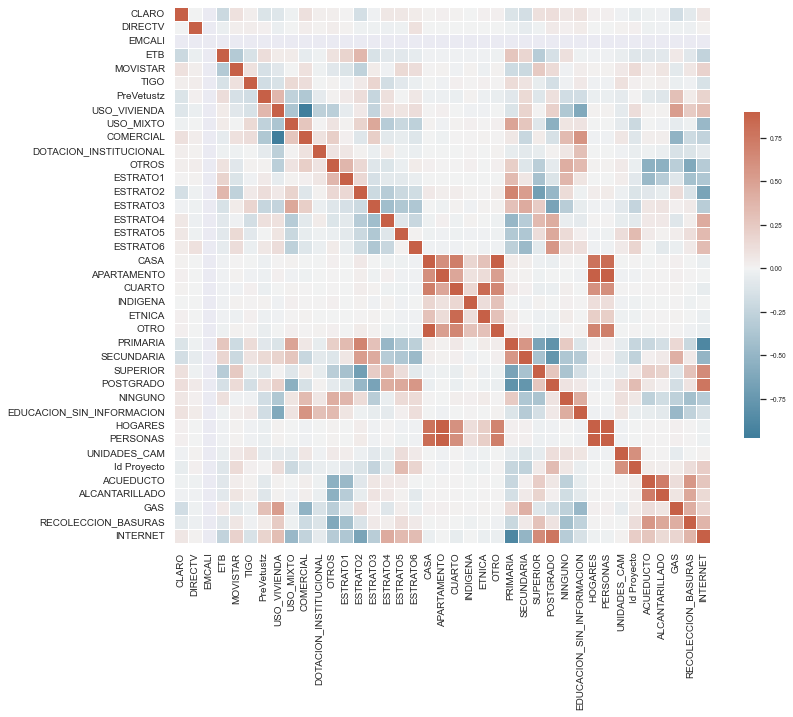

In [80]:
###sns.swarmplot(x=HFC4['ETB_FLAG'],y=HFC4['PreVetustz'])

correlaciones=HFC4.loc[(HFC4.MPIO_CDPMP=="11001") &(HFC4.ETB>0)][['CLARO', 'DIRECTV', 'EMCALI', 'ETB', 'MOVISTAR', 'TIGO', 'PreVetustz',
  'USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS', 'ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6',
  'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION',
 'HOGARES', 'PERSONAS','UNIDADES_CAM','Id Proyecto','ACUEDUCTO', 'ALCANTARILLADO', 'GAS', 'RECOLECCION_BASURAS', 'INTERNET']].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale = 0.6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sns.heatmap(correlaciones, vmax=.9,center=0,cmap=cmap,square=True, linewidths=.5,annot_kws = {"size": 10}, cbar_kws={"shrink": .5},ax = ax)
ax.tick_params(labelsize = 10)

In [81]:
# guardamos HFC4 como  HFC_Operador_Vetustez.geojson
HFC4.to_file(os.path.join(result_dir, "HFC_Operador_Vetustez.geojson"), driver='GeoJSON', encoding='utf-8')

In [82]:
HFC4.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [83]:
HFC4.head()

,NODO,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG
0,LSU,25899,"POLYGON ((-73.99031 5.02734, -73.99026 5.02740...",0.0,0.0,-1.0,0.0,202012.0,0.0,NaN,0.827446,0.011941,0.114387,0.007078,0.039148,0.011268,0.071917,0.583178,0.327314,0.001457,0.000808,1.714094e+07,3.848078e+07,826584.785630,45.306173,7655.629398,15401.871142,0.185914,0.213052,0.504112,0.058401,0.013914,0.024607,3.997419e+07,1.173383e+08,NaN,NaN,0.999331,0.997076,0.946178,0.995140,0.759194,0,0,0,0,1,0
1,EDZ,25899,"POLYGON ((-73.99020 5.02736, -73.98835 5.02794...",0.0,0.0,-1.0,202108.0,202009.0,0.0,NaN,0.828376,0.011936,0.113769,0.007033,0.038887,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,8.583930e+06,1.925283e+07,421262.197540,46.320589,3790.564398,7673.769975,0.187407,0.213373,0.502793,0.057959,0.013959,0.024509,2.003360e+07,5.884675e+07,NaN,NaN,0.999313,0.997089,0.946342,0.995174,0.758069,1,0,0,0,1,0
2,MZQ,25899,"POLYGON ((-74.00267 5.03087, -74.00268 5.03106...",0.0,0.0,-1.0,202104.0,0.0,0.0,NaN,0.760801,0.023492,0.185535,0.012215,0.017956,0.254498,0.316327,0.347693,0.077906,0.000691,0.000281,4.316832e+04,4.323158e+04,5939.502834,0.000000,0.000000,36.104935,0.387955,0.188414,0.355680,0.005102,0.026251,0.036598,6.754518e+04,2.107590e+05,NaN,NaN,0.996064,0.995796,0.901450,0.994383,0.516099,1,0,0,0,0,0
3,ULB,25899,"POLYGON ((-74.00047 5.03564, -74.00103 5.03580...",202010.0,-1.0,-1.0,202106.0,0.0,-1.0,NaN,0.922109,0.011411,0.051400,0.002461,0.012619,0.089782,0.721684,0.183835,0.002531,0.000271,0.000000,1.509101e+06,3.111139e+06,187317.501043,371.236424,0.000000,742.472847,0.324857,0.242429,0.381629,0.017485,0.018103,0.015497,3.796179e+06,1.185875e+07,NaN,NaN,0.997738,0.998190,0.961005,0.998182,0.656930,1,1,0,0,0,0
4,ZSP,25899,"POLYGON ((-73.99945 5.01762, -73.99959 5.01745...",0.0,0.0,-1.0,202010.0,202102.0,202105.0,NaN,0.831795,0.011046,0.109904,0.007563,0.039691,0.010874,0.067321,0.613735,0.301822,0.001337,0.000743,1.506996e+05,3.185949e+05,7604.601531,0.000000,60.119310,120.238620,0.185490,0.209369,0.514339,0.053588,0.013467,0.023748,3.426933e+05,1.011422e+06,NaN,NaN,0.999407,0.995963,0.944968,0.994638,0.760486,1,0,0,0,1,1


## Análisis Lisa

In [84]:
######################################
##############Análisis Lisa############
########################################
coords = points_to_coords(HFC4.geometry.centroid)
q_d=weights.DistanceBand(coords, threshold=1/100, binary=False)##Límite en grados 1/200 ~ 555 mt.
q_d.transform='R'

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

There are 56 disconnected observations 
  Island ids: 44, 904, 916, 917, 919, 921, 938, 939, 977, 1047, 1154, 1431, 1547, 2058, 2132, 2137, 2139, 2141, 2142, 2144, 2145, 2154, 2156, 2281, 2698, 2936, 2969, 2985, 3088, 3141, 3149, 3415, 3417, 3420, 3421, 3423, 3466, 3621, 3623, 3907, 4109, 4140, 4732, 6314, 6857, 11086, 11087, 11109, 12344, 12519, 12680, 12704, 12710, 13006, 13007, 13746


('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 904, ' is an island (no neighbors)')
('WARNING: ', 916, ' is an island (no neighbors)')
('WARNING: ', 917, ' is an island (no neighbors)')
('WARNING: ', 919, ' is an island (no neighbors)')
('WARNING: ', 921, ' is an island (no neighbors)')
('WARNING: ', 938, ' is an island (no neighbors)')
('WARNING: ', 939, ' is an island (no neighbors)')
('WARNING: ', 977, ' is an island (no neighbors)')
('WARNING: ', 1047, ' is an island (no neighbors)')
('WARNING: ', 1154, ' is an island (no neighbors)')
('WARNING: ', 1431, ' is an island (no neighbors)')
('WARNING: ', 1547, ' is an island (no neighbors)')
('WARNING: ', 2058, ' is an island (no neighbors)')
('WARNING: ', 2132, ' is an island (no neighbors)')
('WARNING: ', 2137, ' is an island (no neighbors)')
('WARNING: ', 2139, ' is an island (no neighbors)')
('WARNING: ', 2141, ' is an island (no neighbors)')
('WARNING: ', 2142, ' is an island (no neighbors)')
('WARNING: ', 2144, ' 

In [85]:
HFC4.head(3)

,NODO,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG
0,LSU,25899,"POLYGON ((-73.99031 5.02734, -73.99026 5.02740...",0.0,0.0,-1.0,0.0,202012.0,0.0,NaN,0.827446,0.011941,0.114387,0.007078,0.039148,0.011268,0.071917,0.583178,0.327314,0.001457,0.000808,1.714094e+07,3.848078e+07,826584.785630,45.306173,7655.629398,15401.871142,0.185914,0.213052,0.504112,0.058401,0.013914,0.024607,3.997419e+07,1.173383e+08,NaN,NaN,0.999331,0.997076,0.946178,0.995140,0.759194,0,0,0,0,1,0
1,EDZ,25899,"POLYGON ((-73.99020 5.02736, -73.98835 5.02794...",0.0,0.0,-1.0,202108.0,202009.0,0.0,NaN,0.828376,0.011936,0.113769,0.007033,0.038887,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,8.583930e+06,1.925283e+07,421262.197540,46.320589,3790.564398,7673.769975,0.187407,0.213373,0.502793,0.057959,0.013959,0.024509,2.003360e+07,5.884675e+07,NaN,NaN,0.999313,0.997089,0.946342,0.995174,0.758069,1,0,0,0,1,0
2,MZQ,25899,"POLYGON ((-74.00267 5.03087, -74.00268 5.03106...",0.0,0.0,-1.0,202104.0,0.0,0.0,NaN,0.760801,0.023492,0.185535,0.012215,0.017956,0.254498,0.316327,0.347693,0.077906,0.000691,0.000281,4.316832e+04,4.323158e+04,5939.502834,0.000000,0.000000,36.104935,0.387955,0.188414,0.355680,0.005102,0.026251,0.036598,6.754518e+04,2.107590e+05,NaN,NaN,0.996064,0.995796,0.901450,0.994383,0.516099,1,0,0,0,0,0


In [86]:
#Definir variable con rezago espacial
HFC4['w_ETB_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['ETB_FLAG'])
HFC4['w_CLARO_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['CLARO_FLAG'])
HFC4['w_DIRECTV_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['DIRECTV_FLAG'])
HFC4['w_MOVISTAR_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['MOVISTAR_FLAG'])
HFC4['w_TIGO_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['TIGO_FLAG'])
HFC4['w_EMCALI_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['EMCALI_FLAG'])

In [87]:
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']

In [88]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_ETB_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_ETB_FLAG']=labels_cuenta

In [89]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_CLARO_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_CLARO_FLAG']=labels_cuenta

In [90]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_DIRECTV_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_DIRECTV_FLAG']=labels_cuenta

In [91]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_MOVISTAR_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_MOVISTAR_FLAG']=labels_cuenta

In [92]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_TIGO_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_TIGO_FLAG']=labels_cuenta


In [93]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_EMCALI_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_EMCALI_FLAG']=labels_cuenta

In [94]:
####Estandarizar las clases
columnas_clases=['cl_ETB_FLAG', 'cl_CLARO_FLAG', 'cl_DIRECTV_FLAG', 'cl_MOVISTAR_FLAG', 'cl_TIGO_FLAG', 'cl_EMCALI_FLAG']
for z in columnas_clases:
    HFC4[z]=HFC4[z].apply(lambda x: 'A-A' if x=='Q1' else ('B-A' if x=='Q2' else ('B-B' if x=='Q3' else 'A-B')) )

HFC4=HFC4.set_index('NODO')

In [95]:
#######Clustering######
'''Se realiza un clustering para cada operador
se deben crear un clustering para cada operador'''
###Preparación de la base#####
base_num=HFC4[['USO_VIVIENDA', 'USO_MIXTO', 'COMERCIAL', 'DOTACION_INSTITUCIONAL', 'OTROS', 'ESTRATO1', 'ESTRATO2',
               'ESTRATO3', 'ESTRATO4', 'ESTRATO5', 'ESTRATO6', 'ETB', 'MOVISTAR', 'TIGO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO',
               'UNIDADES_CAM', 'INTERNET', 'ETB_FLAG', 'CLARO_FLAG', 'DIRECTV_FLAG', 'EMCALI_FLAG', 'MOVISTAR_FLAG','TIGO_FLAG' ]].copy()

In [96]:
# Rellenar información de operadores faltantes
base_num['ETB'].fillna(-1,inplace=True)
base_num['TIGO'].fillna(-1,inplace=True)
base_num['MOVISTAR'].fillna(-1,inplace=True)
if modo_ejecucion=='entrenamiento':
    mes_training=[202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104,202105,202106, 202107, 202108, 202109, 202110]
    mes_testing=[202111, 202112]
elif modo_ejecucion=='predicion':
    mes_training=[202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110,202111, 202112]
    mes_testing=[202201, 202202]

In [97]:
#Llenar faltantes
base_num=base_num.fillna(np.mean(base_num))

In [98]:
# Convertir en categoria la variable respuesta
base_num['ETB_FLAG']=base_num['ETB_FLAG'].astype('category').cat.codes
base_num['CLARO_FLAG']=base_num['CLARO_FLAG'].astype('category').cat.codes
base_num['DIRECTV_FLAG']=base_num['DIRECTV_FLAG'].astype('category').cat.codes
base_num['EMCALI_FLAG']=base_num['EMCALI_FLAG'].astype('category').cat.codes
base_num['EMCALI_FLAG']=base_num['EMCALI_FLAG'].astype('category').cat.codes

In [99]:
# Variables independientes
# Lables de columnas
cols_x = base_num[base_num.columns.difference(['ETB_FLAG', 'CLARO_FLAG', 'DIRECTV_FLAG', 'EMCALI_FLAG', 'MOVISTAR_FLAG','TIGO_FLAG'])].columns
X = base_num[base_num.columns.difference(['ETB_FLAG', 'CLARO_FLAG','DIRECTV_FLAG', 'EMCALI_FLAG','MOVISTAR_FLAG','TIGO_FLAG'])].values

In [100]:
base_num.shape

(13759, 26)

In [101]:
base_num

,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,ETB,MOVISTAR,TIGO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,UNIDADES_CAM,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,
LSU,0.827446,0.011941,0.114387,0.007078,0.039148,0.011268,0.071917,0.583178,0.327314,0.001457,0.000808,0.0,202012.0,0.0,0.185914,0.213052,0.504112,0.058401,57.79363,0.759194,0,0,0,0,1,0
EDZ,0.828376,0.011936,0.113769,0.007033,0.038887,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,202108.0,202009.0,0.0,0.187407,0.213373,0.502793,0.057959,57.79363,0.758069,1,0,0,0,1,0
MZQ,0.760801,0.023492,0.185535,0.012215,0.017956,0.254498,0.316327,0.347693,0.077906,0.000691,0.000281,202104.0,0.0,0.0,0.387955,0.188414,0.355680,0.005102,57.79363,0.516099,1,0,0,0,0,0
ULB,0.922109,0.011411,0.051400,0.002461,0.012619,0.089782,0.721684,0.183835,0.002531,0.000271,0.000000,202106.0,0.0,-1.0,0.324857,0.242429,0.381629,0.017485,57.79363,0.656930,1,1,0,0,0,0
ZSP,0.831795,0.011046,0.109904,0.007563,0.039691,0.010874,0.067321,0.613735,0.301822,0.001337,0.000743,202010.0,202102.0,202105.0,0.185490,0.209369,0.514339,0.053588,57.79363,0.760486,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S2D,0.931233,0.025788,0.034363,0.006881,0.001736,0.287998,0.697321,0.009037,0.000007,0.000000,0.000939,-1.0,202108.0,202109.0,0.257609,0.229119,0.477040,0.000004,57.79363,0.718475,0,0,0,0,1,1
S2D3B,0.933673,0.024896,0.030711,0.007087,0.003634,0.254694,0.671195,0.071714,0.000799,0.000000,0.000200,-1.0,0.0,202010.0,0.356164,0.105766,0.488054,0.000531,57.79363,0.734783,0,0,0,0,0,1
VQ1,0.882905,0.015020,0.079424,0.006026,0.016625,0.089895,0.265295,0.324156,0.173695,0.078722,0.064290,-1.0,-1.0,-1.0,0.253107,0.202600,0.406685,0.077516,57.79363,0.740936,1,1,1,1,1,1


In [102]:
# para ver que tipo de variables tiene las columnas
categori_columna_x=base_num.ETB_FLAG.value_counts()
categori_columna_x

0    9188
1    4571
Name: ETB_FLAG, dtype: int64

In [103]:
mes_training.sort()
mes_training

[202009,
 202010,
 202011,
 202012,
 202101,
 202102,
 202103,
 202104,
 202105,
 202106,
 202107,
 202108,
 202109,
 202110,
 202111,
 202112]

In [104]:
mes_testing.sort()
mes_testing

[202201, 202202]

## ETB

In [105]:
#####ETB######
y = base_num['ETB_FLAG'].values
# Dividimos en Train en meses anteriores a junio, Test 2 últimos meses
X_train=X[base_num['ETB'].isin(mes_training)]
X_test=X[base_num['ETB'].isin(mes_testing)]
y_train=y[base_num['ETB'].isin(mes_training)]
y_test=y[base_num['ETB'].isin(mes_testing)]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X[base_num['ETB'].isin([0,-1])], y[base_num['ETB'].isin([0,-1])], test_size=0.5, random_state=1)

X_train_etb=np.concatenate([X_train,X_train2])
y_train_etb=np.concatenate([y_train,y_train2])
X_test_etb=np.concatenate([X_test,X_test2])
y_test_etb=np.concatenate([y_test,y_test2])

In [106]:
y_para_nuevoetb=base_num[base_num['ETB'].isin(mes_testing)][['ETB']]
y_para_nuevoetb.head()

,ETB
NODO,


In [107]:
y_train_etb.shape

(6040,)

In [108]:
# Definir el clasificador
nombreModelo = f"D:\\Will_Analisis\\Expansion_Fija\\2_Script\\dtc_ETB.pkl"
if modo_ejecucion=='entrenamiento':
    dtc_ETB = tree.DecisionTreeClassifier()
    dtc_ETB = dtc_ETB.fit(X_train_etb,y_train_etb)
    # prediccion de X_test_etb
    # y_pred_etb1=y_pred_etb.copy()
    # para guadar el modelo    
    dump(dtc_ETB, nombreModelo)
elif modo_ejecucion=='predicion':
    dtc_ETB=load(nombreModelo)
    
y_pred_etb = dtc_ETB.predict(X_test_etb) 

In [109]:
#Métricas
if modo_ejecucion=='entrenamiento':
    print("Exactitud:", metrics.accuracy_score(y_test_etb, y_pred_etb)) #0.91   #0.99
    print("Precisión:", metrics.precision_score(y_test_etb, y_pred_etb))    #0.85   #0.86
    print("Recall:", metrics.recall_score(y_test_etb, y_pred_etb))  #0.845      #0.89
    print("F1 Score:", metrics.f1_score(y_test_etb, y_pred_etb)) #0.852     #0.89
    print("ROC AUC Score:", roc_auc_score(y_test_etb, y_pred_etb))  #0.893  #0.94

In [110]:
from sklearn.metrics import confusion_matrix
if modo_ejecucion=='entrenamiento':
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
    matrizConfucion = confusion_matrix(y_test_etb, y_pred_etb)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['0','1'], columns=['0','1'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g',annot_kws={"size": 16})
    axes.tick_params(labelsize = 20)
    plt.title('ETB')

In [111]:
# Calculamos las curvas ROC
from sklearn.metrics import roc_curve
if modo_ejecucion=='entrenamiento':
    ns_probs = [0 for _ in range(len(y_test_etb))]
    # ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test_etb, ns_probs)

    fpr1, tpr1, _ = roc_curve(y_test_etb, y_pred_etb)
    auc1 =roc_auc_score(y_test_etb, y_pred_etb)
    print('ROC AUC', auc1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(fpr1, tpr1, marker='.', label='DecisionTreeClassifier')
    # Etiquetas de los ejes
    plt.legend()
    plt.title('ROC ETB')
    plt.show()

In [112]:
## import shap
# df_x_train_etb=pd.DataFrame(X_train_etb,columns=base_num.columns)
# shap_test = df_x_train_etb
# shap_values = shap.TreeExplainer(dtc_ETB).shap_values(df_x_train_etb)
# plt.figure()
# plt.title('ttt')
# shap.summary_plot(shap_values, shap_test,max_display=30)
# plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
# plt.show();
if modo_ejecucion=='entrenamiento':
    shap_test = X_train_etb
    shap_values = shap.TreeExplainer(dtc_ETB).shap_values(X_train_etb)
    plt.figure()
    plt.title('variables de mas ajuste')
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();
# para saber a cual pertenece cada caraacteristica se debe mirar en base_num.columns y se cuenta iniciando en 0     por lo que feature 8 es Estrato 4

In [113]:
base_num.columns

Index(['USO_VIVIENDA', 'USO_MIXTO', 'COMERCIAL', 'DOTACION_INSTITUCIONAL',
       'OTROS', 'ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4', 'ESTRATO5',
       'ESTRATO6', 'ETB', 'MOVISTAR', 'TIGO', 'PRIMARIA', 'SECUNDARIA',
       'SUPERIOR', 'POSTGRADO', 'UNIDADES_CAM', 'INTERNET', 'ETB_FLAG',
       'CLARO_FLAG', 'DIRECTV_FLAG', 'EMCALI_FLAG', 'MOVISTAR_FLAG',
       'TIGO_FLAG'],
      dtype='object')

### MOVISTAR

In [114]:
#####MOVISTAR######
y = base_num['MOVISTAR_FLAG'].values
X_train=X[base_num['MOVISTAR'].isin(mes_training)]
X_test=X[base_num['MOVISTAR'].isin(mes_testing)]
y_train=y[base_num['MOVISTAR'].isin(mes_training)]
y_test=y[base_num['MOVISTAR'].isin(mes_testing)]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X[base_num['MOVISTAR'].isin([0,-1])], y[base_num['MOVISTAR'].isin([0,-1])], test_size=0.5, random_state=1)
X_train_mov=np.concatenate([X_train,X_train1])
y_train_mov=np.concatenate([y_train,y_train1])
X_test_mov=np.concatenate([X_test,X_test1])
y_test_mov=np.concatenate([y_test,y_test1])

In [115]:
y_para_nuevomov=base_num[base_num['MOVISTAR'].isin(mes_testing)][['MOVISTAR']]
y_para_nuevomov.head()

,MOVISTAR
NODO,


In [116]:
# Definir el clasificador
nombreModelo = f"D:\\Will_Analisis\\Expansion_Fija\\2_Script\\dtc_movistar.pkl"
if modo_ejecucion=='entrenamiento':
    dtc_movistar = tree.DecisionTreeClassifier()
    dtc_movistar = dtc_movistar.fit(X_train_mov,y_train_mov)
    dump(dtc_movistar, nombreModelo)
elif modo_ejecucion=='predicion':
    dtc_movistar=load(nombreModelo)
    
y_pred_mov = dtc_movistar.predict(X_test_mov)    
y_pred_mov1=y_pred_mov.copy()

In [117]:
#Métricas
if modo_ejecucion=='entrenamiento':
    print("Exactitud:", metrics.accuracy_score(y_test_mov, y_pred_mov)) #0.8    #0.99
    print("Precisión:", metrics.precision_score(y_test_mov, y_pred_mov))    #0.68   #0.98
    print("Recall:", metrics.recall_score(y_test_mov, y_pred_mov))  #0.64   #0.96
    print("F1 Score:", metrics.f1_score(y_test_mov, y_pred_mov))    #0.66   #0.97
    print("ROC AUC Score:",  roc_auc_score(y_test_mov, y_pred_mov))  #0.75   #0.97

In [118]:
if modo_ejecucion=='entrenamiento':
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
    matrizConfucion = confusion_matrix(y_test_mov, y_pred_mov)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['0','1'], columns=['0','1'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g',annot_kws={"size": 16})
    axes.tick_params(labelsize = 10)
    plt.title('Movistar')

In [119]:
# Calculamos las curvas ROC
from sklearn.metrics import roc_curve
if modo_ejecucion=='entrenamiento':
    ns_probs = [0 for _ in range(len(y_test_mov))]
    # ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test_mov, ns_probs)

    fpr1, tpr1, _ = roc_curve(y_test_mov, y_pred_mov)
    auc1 =roc_auc_score(y_test_mov, y_pred_mov)
    print('ROC AUC', auc1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(fpr1, tpr1, marker='.', label='DecisionTreeClassifier')
    # Etiquetas de los ejes
    plt.title('ROC Movistar')
    plt.legend()
    plt.show()

In [120]:
import shap
if modo_ejecucion=='entrenamiento':
    shap_test = X_train_mov
    shap_values = shap.TreeExplainer(dtc_movistar).shap_values(X_train_mov)
    plt.figure()
    plt.title('ttt')
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

### TIGO

In [121]:
##### TIGO ######
y = base_num['TIGO_FLAG'].values
X_train=X[base_num['TIGO'].isin(mes_training)]
X_test=X[base_num['TIGO'].isin(mes_testing)]
y_train=y[base_num['TIGO'].isin(mes_training)]
y_test=y[base_num['TIGO'].isin(mes_testing)]
X_train0, X_test0, y_train0, y_test0 = train_test_split(X[base_num['TIGO'].isin([0,-1])], y[base_num['TIGO'].isin([0,-1])], test_size=0.5, random_state=1)
X_train_tigo=np.concatenate([X_train,X_train0])
y_train_tigo=np.concatenate([y_train,y_train0])
X_test_tigo=np.concatenate([X_test,X_test0])
y_test_tigo=np.concatenate([y_test,y_test0])

In [122]:
y_para_nuevotig=base_num[base_num['TIGO'].isin(mes_testing)][['TIGO']]
y_para_nuevotig.head()

,TIGO
NODO,


In [123]:
# Definir el clasificador
nombreModelo = f"D:\\Will_Analisis\\Expansion_Fija\\2_Script\\dtc_tigo.pkl"
if modo_ejecucion=='entrenamiento':
    dtc_tigo = tree.DecisionTreeClassifier()
    dtc_tigo = dtc_tigo.fit(X_train_tigo,y_train_tigo)
    dump(dtc_tigo, nombreModelo)
elif modo_ejecucion=='predicion':
    dtc_tigo=load(nombreModelo)
y_pred_tigo = dtc_tigo.predict(X_test_tigo)
y_pred_tigo1=y_pred_tigo.copy()

In [124]:
#Métricas
if modo_ejecucion=='entrenamiento':
    print("Exactitud:", metrics.accuracy_score(y_test_tigo, y_pred_tigo)) #0.745  #0.99
    print("Precisión:", metrics.precision_score(y_test_tigo, y_pred_tigo))    #0.43   #0.97
    print("Recall:", metrics.recall_score(y_test_tigo, y_pred_tigo))  #0.377      #0.97
    print("F1 Score:", metrics.f1_score(y_test_tigo, y_pred_tigo))    #0.4    #0.975
    print("ROC AUC Score:", roc_auc_score(y_test_tigo, y_pred_tigo))  #0.61   0.98

In [125]:

if modo_ejecucion=='entrenamiento':
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
    matrizConfucion = confusion_matrix(y_test_tigo, y_pred_tigo)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['0','1'], columns=['0','1'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g',annot_kws={"size": 16})
    axes.tick_params(labelsize = 20)
    plt.title('Tigo')

In [126]:
# Calculamos las curvas ROC
if modo_ejecucion=='entrenamiento':
    ns_probs = [0 for _ in range(len(y_test_tigo))]
    # ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test_tigo, ns_probs)


    fpr1, tpr1, _ = roc_curve(y_test_tigo, y_pred_tigo)
    auc1 =roc_auc_score(y_test_tigo, y_pred_tigo)
    print('ROC AUC', auc1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(fpr1, tpr1, marker='.', label='DecisionTreeClassifier')
    # Etiquetas de los ejes
    plt.title('ROC Tigo')
    plt.legend()
    plt.show()

In [127]:
if modo_ejecucion=='entrenamiento':
    shap_test = X_train_tigo
    shap_values = shap.TreeExplainer(dtc_tigo).shap_values(X_train_tigo)
    plt.figure()
    plt.title('ttt')
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

In [128]:
# para guadar el modelo
# from joblib import dump,load
# nombreModelo = f"C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\2_Script\\dtc_movistar.pkl"
# dump(dtc_movistar, nombreModelo)

## Predicciones

In [129]:
######Predicciones#######
HFC4.loc[HFC4.ETB_FLAG==0, 'PRED_ETB']= dtc_ETB.predict(base_num.loc[base_num.ETB_FLAG==0][cols_x])
HFC4.loc[HFC4.MOVISTAR_FLAG==0, 'PRED_MOVISTAR']=dtc_movistar.predict(base_num.loc[base_num.MOVISTAR_FLAG==0][cols_x])
HFC4.loc[HFC4.TIGO_FLAG==0, 'PRED_TIGO']=dtc_tigo.predict(base_num.loc[base_num.TIGO_FLAG==0][cols_x])

HFC4['PRED_ETB']=HFC4['PRED_ETB'].fillna(2)
HFC4['PRED_MOVISTAR']=HFC4['PRED_MOVISTAR'].fillna(2)
HFC4['PRED_TIGO']=HFC4['PRED_TIGO'].fillna(2)

X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names


In [130]:
HFC4.sample(3)

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C5O,05001,"POLYGON ((-75.55945 6.27264, -75.55948 6.27261...",0.0,0.0,-1.0,-1.0,-1.0,202008.0,NaN,0.927099,0.012262,0.057116,0.001511,0.002012,0.007063,0.660522,0.329616,0.001668,0.000481,0.000000e+00,3.788592e+04,2.923859e+04,4.090931e+03,0.000000,0.000000,32.645253,0.324576,0.355317,0.257247,0.004341,0.029744,0.028775,6.578268e+04,1.752929e+05,NaN,NaN,0.998736,0.985863,0.824300,0.991296,0.643691,0,0,0,0,0,1,0.013795,0.478829,0.000000,0.016839,1.000000,0.0,B-B,A-A,B-B,B-B,A-A,B-B,0.0,0.0,2.0
TRO,68276,"POLYGON ((-73.09777 7.08758, -73.09746 7.08751...",0.0,-1.0,-1.0,-1.0,0.0,0.0,NaN,0.887146,0.023150,0.042705,0.000919,0.046080,0.398302,0.530805,0.062744,0.002595,0.004212,8.530684e-07,3.124143e+07,9.049210e+07,2.861841e+06,12204.446777,100.675147,51209.997503,0.527564,0.134550,0.267539,0.007801,0.037904,0.024641,1.048317e+08,3.527673e+08,NaN,NaN,0.948221,0.982142,0.971035,0.996321,0.594888,0,0,0,0,0,0,0.038102,0.000000,0.000000,0.000000,0.040074,0.0,B-B,B-B,B-B,B-B,B-B,B-B,0.0,0.0,0.0
0UE,41001,"POLYGON ((-75.26774 2.93121, -75.26775 2.93112...",0.0,-1.0,-1.0,-1.0,0.0,-1.0,NaN,0.909786,0.021640,0.054377,0.005480,0.008717,0.330907,0.339301,0.154063,0.157024,0.011625,4.185156e-03,6.745982e+04,5.758594e+04,3.362314e+03,0.000000,0.000000,49.093379,0.360753,0.222145,0.277759,0.044008,0.050305,0.045031,9.053889e+04,2.605785e+05,NaN,NaN,0.997476,0.994541,0.978164,0.996550,0.633468,0,0,0,0,0,0,0.408819,0.078410,0.033792,0.414979,0.000000,0.0,A-B,B-B,A-A,A-B,B-B,B-B,0.0,0.0,0.0


In [131]:
### Análisis local espacial de instalaciones recientes
HFC5=HFC4.copy()

## Función lisa

In [132]:
##Función lisa
def LISA(capa, variable):
    capa["Reciente"]=capa[variable].apply(lambda x: 1 if x>202111 else (0 if x<1 else 2))
    capa=capa.loc[capa.Reciente.isin([1,0])]
    coords = points_to_coords(capa.geometry.centroid)
    q_d = weights.DistanceBand(coords, threshold=1 / 200, binary=False)  ##Límite en grados 1/200 ~ 555 mt.
    q_d.transform = 'R'
        # Definir variable con rezago espacial
    capa['VAR_REZAGO'] = weights.spatial_lag.lag_spatial(q_d, capa["Reciente"])
    q_labels = ['Q1', 'Q2', 'Q3', 'Q4']

    lisa_cuenta = esda.moran.Moran_Local(capa['VAR_REZAGO'], q_d) # moran.Moran_Loca analisis de correlacion 
    labels_cuenta = [q_labels[i - 1] for i in lisa_cuenta.q]
    variable_clase="cl_Rec_"+variable
    capa[variable_clase] = labels_cuenta
    capa[variable_clase] = capa[variable_clase].apply(lambda x: 'A-A' if x == 'Q1' else ('B-A' if x == 'Q2' else ('B-B' if x == 'Q3' else 'A-B')))
    return capa[[variable_clase]]

pd.notnull

<function pandas.core.dtypes.missing.notna(obj)>

### Unir resultados

In [133]:
### Unir resultados de HFC5
HFC5=HFC5.merge(LISA(HFC5.copy(), "ETB"),right_index=True, left_index=True,how="left")
HFC5=HFC5.merge(LISA(HFC5.copy(), "MOVISTAR"),right_index=True, left_index=True,how="left")
HFC5=HFC5.merge(LISA(HFC5.copy(), "TIGO"),right_index=True, left_index=True,how="left")

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

There are 279 disconnected observations 
  Island ids: 0, 3, 5, 9, 10, 15, 16, 25, 26, 27, 34, 98, 417, 442, 449, 479, 484, 486, 487, 491, 497, 509, 510, 528, 561, 692, 780, 782, 814, 824, 826, 827, 828, 829, 830, 844, 845, 870, 871, 872, 875, 877, 881, 889, 905, 906, 922, 923, 925, 927, 929, 930, 931, 1008, 1022, 1023, 1040, 1299, 1327, 1335, 1398, 1533, 1534, 1552, 1556, 1559, 1575, 1678, 1696, 1706, 1735, 1741, 1742, 1835, 1837, 1849, 1854, 1855, 1857, 1908, 1911, 1916, 1917, 1918, 1919, 1921, 1922, 1924, 1927, 1954, 1964, 1983, 1987, 2004, 2010, 2030, 2040, 2045, 2053, 2120, 2261, 2263, 2264, 2424, 2425, 2426, 2446, 2460, 2466, 2561, 2697, 2726, 2730, 2745, 2746, 2764, 2847, 2855, 2900, 2903, 2907, 2908, 2909, 2923, 2936, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3168, 3169, 3171, 3192, 3212, 3304, 3322, 33

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 34, ' is an island (no neighbors)')
('WARNING: ', 98, ' is an island (no neighbors)')
('WARNING: ', 417, ' is an island (no neighbors)')
('WARNING: ', 442, ' is an island (no neighbors)')
('WARNING: ', 449, ' is an island (no neighbors)')
('WARNING: ', 479, ' is an island (no neighbors)')
('WARNING: ', 484, ' is an island (no neighbors)')
('WARNING: ', 486, ' is an island (no neighbors)')
('WARNING: ', 487, ' is an island (no neighbors)')
('WARNING: ', 491, ' is an island (no neighbors


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
There are 342 disconnected observations 
  Island ids: 4, 17, 25, 39, 43, 50, 89, 114, 115, 121, 476, 483, 493, 494, 496, 499, 502, 503, 504, 505, 506, 510, 511, 528, 534, 535, 536, 545, 546, 549, 550, 561, 566, 570, 573, 574, 585, 594, 595, 596, 597, 598, 599, 601, 602, 603, 604, 605, 606, 607, 608, 609, 611, 648, 650, 655, 656, 657, 658, 737, 751, 752, 769, 1019, 1020, 1021, 1022, 1023, 1036, 1102, 1198, 1210, 1230, 1231, 1249, 1253, 1256, 1262, 1284, 1315, 1400, 1402, 1414, 1418, 1419, 1421, 1472, 1475, 1480, 1481, 1482, 1483, 1484, 1486, 1487, 1488, 1493, 1496, 1498, 1509, 1515, 1516, 1523, 1540, 1544, 1561, 1567, 1587, 1597, 1602, 1610, 1676, 1816, 1818, 1819, 1820, 1834, 1835, 1838, 1839, 1854, 1868, 1874, 1966, 2098, 21

('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 114, ' is an island (no neighbors)')
('WARNING: ', 115, ' is an island (no neighbors)')
('WARNING: ', 121, ' is an island (no neighbors)')
('WARNING: ', 476, ' is an island (no neighbors)')
('WARNING: ', 483, ' is an island (no neighbors)')
('WARNING: ', 493, ' is an island (no neighbors)')
('WARNING: ', 494, ' is an island (no neighbors)')
('WARNING: ', 496, ' is an island (no neighbors)')
('WARNING: ', 499, ' is an island (no neighbors)')
('WARNING: ', 502, ' is an island (no neighbors)')
('WARNING: ', 503, ' is an island (no neighbors)')
('WARNING: ', 504, ' is an island (no neighbors)')
('WARNING: ', 505, ' is an island (no n

There are 317 disconnected observations 
  Island ids: 23, 25, 33, 37, 50, 67, 75, 140, 507, 514, 541, 547, 549, 550, 553, 557, 560, 567, 568, 572, 598, 756, 766, 795, 805, 807, 808, 809, 810, 812, 817, 820, 821, 823, 825, 831, 838, 840, 860, 896, 897, 899, 901, 905, 906, 907, 987, 1001, 1018, 1034, 1053, 1056, 1095, 1096, 1159, 1255, 1263, 1279, 1280, 1298, 1302, 1305, 1489, 1499, 1537, 1538, 1546, 1547, 1548, 1549, 1550, 1551, 1553, 1565, 1570, 1571, 1573, 1624, 1627, 1632, 1633, 1634, 1635, 1636, 1637, 1639, 1640, 1641, 1646, 1649, 1651, 1678, 1684, 1685, 1702, 1708, 1728, 1738, 1743, 1751, 1816, 1923, 1935, 1937, 1938, 2089, 2091, 2092, 2093, 2110, 2127, 2222, 2357, 2384, 2388, 2403, 2404, 2422, 2500, 2507, 2552, 2555, 2559, 2560, 2561, 2576, 2586, 2664, 2670, 2678, 2679, 2680, 2703, 2704, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2715, 2716, 2718, 2740, 2760, 2851, 2869, 2878, 2899, 2903, 2947, 3066, 3083, 3089, 3097, 3120, 3137, 3139, 3140, 3159, 3176, 3247, 3248, 3249, 3309, 331

('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 67, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 507, ' is an island (no neighbors)')
('WARNING: ', 514, ' is an island (no neighbors)')
('WARNING: ', 541, ' is an island (no neighbors)')
('WARNING: ', 547, ' is an island (no neighbors)')
('WARNING: ', 549, ' is an island (no neighbors)')
('WARNING: ', 550, ' is an island (no neighbors)')
('WARNING: ', 553, ' is an island (no neighbors)')
('WARNING: ', 557, ' is an island (no neighbors)')
('WARNING: ', 560, ' is an island (no neighbors)')
('WARNING: ', 567, ' is an island (no neighbors)')
('WARNING: ', 568, ' is an island (no neighbors)')
('WARNING: ', 572, ' is an island (no 

In [134]:
HFC5.sample(4)

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO,cl_Rec_ETB,cl_Rec_MOVISTAR,cl_Rec_TIGO
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JN22D,11001,"POLYGON ((-74.06996 4.71956, -74.07000 4.71946...",202110.0,202108.0,-1.0,202008.0,202008.0,202107.0,1978.0,0.923304,0.006677,0.065344,0.002003,0.002671,0.000340,0.003852,0.422955,0.099479,0.469182,0.002153,6.357050e+04,1.853137e+05,1.157042e+04,26.721520,26.721520,0.000000,0.147050,0.179318,0.477003,0.155040,0.019822,0.021768,2.235045e+05,5.969414e+05,NaN,NaN,0.999434,0.998642,0.949406,0.998076,0.889191,1,1,1,0,1,1,0.987536,0.644379,0.024339,0.974784,0.459627,0.024339,A-A,A-A,A-A,A-A,A-A,B-B,2.0,2.0,2.0,NaN,NaN,NaN
GTM1,76001,"POLYGON ((-76.52930 3.40467, -76.52895 3.40468...",0.0,0.0,0.0,-1.0,0.0,0.0,NaN,0.989017,0.001354,0.007226,0.001084,0.001318,0.002008,0.001900,0.401749,0.588443,0.005245,0.000000,4.130949e+04,2.588778e+05,9.828793e+02,0.000000,0.000000,159.500978,0.124985,0.294298,0.464697,0.095510,0.009870,0.010640,2.579680e+05,6.558078e+05,NaN,NaN,0.999937,0.999261,0.970735,0.999282,0.902928,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.111840,0.026722,0.326063,B-B,B-B,B-B,B-B,B-B,A-A,0.0,0.0,0.0,B-B,B-B,B-B
AOD,76364,"POLYGON ((-76.52347 3.27816, -76.52347 3.27817...",0.0,-1.0,-1.0,-1.0,0.0,0.0,NaN,0.900181,0.007260,0.019359,0.006050,0.067151,0.006122,0.035714,0.236735,0.707143,0.011224,0.001020,1.156809e+05,1.974819e+04,4.529402e+02,0.000000,0.000000,0.000000,0.166466,0.279855,0.428629,0.099316,0.010454,0.015279,8.007786e+04,2.399889e+05,NaN,NaN,0.998980,1.000000,0.940816,0.986735,0.853061,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.216589,B-B,B-B,B-B,B-B,B-B,A-A,0.0,0.0,0.0,B-B,B-B,B-B
7VR,47001,"POLYGON ((-74.22594 11.19517, -74.22594 11.195...",0.0,-1.0,-1.0,-1.0,202010.0,0.0,NaN,0.820630,0.002384,0.050345,0.007977,0.118664,0.349653,0.140390,0.087900,0.160743,0.091819,0.167983,5.649048e+07,6.069595e+07,6.800347e+06,24305.895331,24376.974054,12300.140348,0.402934,0.013795,0.312167,0.147387,0.081824,0.041894,6.428012e+07,1.852937e+08,NaN,NaN,0.657995,0.869078,0.616919,0.883054,0.455323,0,0,0,0,1,0,0.020256,0.060645,0.020256,0.953344,0.799355,0.020256,B-B,B-B,A-A,A-A,A-A,B-A,0.0,2.0,0.0,B-B,NaN,B-B


In [135]:
### Extracción del resultado
HFC5.to_file(os.path.join(result_dir, "HFC_PREDICCION_NUEVA.geojson"), driver='GeoJSON', encoding='utf-8')

In [136]:
### Extracción del resultado
HFC5.to_file(os.path.join(result_dir, "HFC_PREDICCION_NUEVA.csv"), encoding='utf-8')

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


In [137]:
HFC5.to_csv('D:\\Will_Analisis\\Expansion_Fija\\3_Resultados\\resultados_pred_nueva.csv', encoding='utf-8',sep=',')

In [138]:
pd.set_option('display.max_columns', None)
HFC5.head(2)

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO,cl_Rec_ETB,cl_Rec_MOVISTAR,cl_Rec_TIGO
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LSU,25899,"POLYGON ((-73.99031 5.02734, -73.99026 5.02740...",0.0,0.0,-1.0,0.0,202012.0,0.0,NaN,0.827446,0.011941,0.114387,0.007078,0.039148,0.011268,0.071917,0.583178,0.327314,0.001457,0.000808,1.714094e+07,3.848078e+07,826584.78563,45.306173,7655.629398,15401.871142,0.185914,0.213052,0.504112,0.058401,0.013914,0.024607,3.997419e+07,1.173383e+08,NaN,NaN,0.999331,0.997076,0.946178,0.995140,0.759194,0,0,0,0,1,0,0.795338,0.020964,0.0,0.700087,0.045566,0.0,A-A,B-B,B-B,A-A,B-B,B-B,0.0,2.0,0.0,B-B,NaN,B-B
EDZ,25899,"POLYGON ((-73.99020 5.02736, -73.98835 5.02794...",0.0,0.0,-1.0,202108.0,202009.0,0.0,NaN,0.828376,0.011936,0.113769,0.007033,0.038887,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,8.583930e+06,1.925283e+07,421262.19754,46.320589,3790.564398,7673.769975,0.187407,0.213373,0.502793,0.057959,0.013959,0.024509,2.003360e+07,5.884675e+07,NaN,NaN,0.999313,0.997089,0.946342,0.995174,0.758069,1,0,0,0,1,0,0.595839,0.023487,0.0,0.686767,0.027393,0.0,A-A,B-B,B-B,A-A,B-B,B-B,2.0,2.0,0.0,NaN,NaN,B-B


In [139]:
categori_Tigo=HFC5.cl_Rec_TIGO.value_counts()
categori_Tigo

B-B    7592
A-A     816
B-A     491
A-B      78
Name: cl_Rec_TIGO, dtype: int64

In [140]:
categori_Movistar=HFC5.cl_Rec_MOVISTAR.value_counts()
categori_Movistar

B-B    7661
A-A     416
B-A     253
A-B      16
Name: cl_Rec_MOVISTAR, dtype: int64

In [141]:
categori_ETB=HFC5.cl_Rec_ETB.value_counts()
categori_ETB

B-B    8772
B-A     236
A-A     211
A-B       5
Name: cl_Rec_ETB, dtype: int64

# Categorias por Variable a predecir

In [142]:
categori_ETB=HFC5.ETB.value_counts()
categori_ETB

-1.0         7223
 202008.0    3016
 0.0         1965
 202009.0     307
 202102.0     257
 202010.0     129
 202103.0     125
 202011.0      82
 202104.0      61
 202012.0      61
 202007.0      60
 202105.0      56
 202101.0      53
 202106.0      49
 202108.0      45
 202107.0      41
 202111.0      40
 202112.0      36
 202110.0      29
 202109.0      27
Name: ETB, dtype: int64

In [143]:
categori_MOVISTAR=HFC5.MOVISTAR.value_counts(ascending=False)
categori_MOVISTAR

 0.0         5994
-1.0         2220
 202008.0     968
 202101.0     543
 202009.0     487
 202012.0     434
 202102.0     386
 202010.0     329
 202011.0     286
 202103.0     272
 202105.0     243
 202104.0     239
 202107.0     206
 202109.0     202
 202106.0     202
 202108.0     191
 202110.0     163
 202111.0     153
 202112.0     132
 202007.0      12
Name: MOVISTAR, dtype: int64

In [144]:
categori_TIGO=HFC5.TIGO.value_counts(ascending=False)
categori_TIGO

 0.0         6685
-1.0         2113
 202008.0     778
 202009.0     674
 202010.0     499
 202011.0     368
 202012.0     337
 202106.0     223
 202105.0     212
 202104.0     212
 202101.0     205
 202112.0     179
 202110.0     177
 202103.0     175
 202102.0     171
 202111.0     170
 202109.0     168
 202108.0     159
 202107.0     153
 202007.0       4
Name: TIGO, dtype: int64

In [145]:
HFC5.shape

(13759, 65)

In [146]:
HFC5.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [147]:
# HFC5.explore("cl_Rec_ETB", legend=False)
# pip install xarray

In [148]:

# import geoviews as gv
# import geoviews.feature as gf
# import xarray as xr
# from cartopy import crs

# gv.Polygons(gpd.read_file(gpd.HFC5.get_path('w_EMCALI_FLAG')), vdims=['pop_est', ('name', 'Country')]).opts(
#     tools=['hover'], width=600, projection=crs.Robinson()
# ) # small_areas_points

In [149]:
# gv.Polygons(gpd.read_file(gpd.HFC5.get_path('naturalearth_lowres')), vdims=['pop_est', ('name', 'Country')]).opts(
#     tools=['hover'], width=600, projection=crs.Robinson()

In [150]:
HFC5_M=HFC5.copy()
HFC5_M=HFC5_M.to_crs({'init':'epsg:3857'}) # Copio GeoDataFrame y cambio la proyección a un sistema cartesiano (EPSG:3857,unidad=m)
# print(HFC5_M).crstost.head(2)

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


In [151]:
# https://sisteme-ig.com/questions/5180/obtener-areas-de-poligonos-usando-geopandas
# area de cada poligono   (devuelta en m ^ 2)
HFC5_M["area"] = HFC5_M['geometry'].area/ 10**6  # Ahora el area en km^2
HFC5_M.head(2)

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO,cl_Rec_ETB,cl_Rec_MOVISTAR,cl_Rec_TIGO,area
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LSU,25899,"POLYGON ((-8236564.189 560360.757, -8236558.51...",0.0,0.0,-1.0,0.0,202012.0,0.0,NaN,0.827446,0.011941,0.114387,0.007078,0.039148,0.011268,0.071917,0.583178,0.327314,0.001457,0.000808,1.714094e+07,3.848078e+07,826584.78563,45.306173,7655.629398,15401.871142,0.185914,0.213052,0.504112,0.058401,0.013914,0.024607,3.997419e+07,1.173383e+08,NaN,NaN,0.999331,0.997076,0.946178,0.995140,0.759194,0,0,0,0,1,0,0.795338,0.020964,0.0,0.700087,0.045566,0.0,A-A,B-B,B-B,A-A,B-B,B-B,0.0,2.0,0.0,B-B,NaN,B-B,0.048703
EDZ,25899,"POLYGON ((-8236551.499 560363.104, -8236345.00...",0.0,0.0,-1.0,202108.0,202009.0,0.0,NaN,0.828376,0.011936,0.113769,0.007033,0.038887,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,8.583930e+06,1.925283e+07,421262.19754,46.320589,3790.564398,7673.769975,0.187407,0.213373,0.502793,0.057959,0.013959,0.024509,2.003360e+07,5.884675e+07,NaN,NaN,0.999313,0.997089,0.946342,0.995174,0.758069,1,0,0,0,1,0,0.595839,0.023487,0.0,0.686767,0.027393,0.0,A-A,B-B,B-B,A-A,B-B,B-B,2.0,2.0,0.0,NaN,NaN,B-B,0.048118


In [152]:
# # https://sisteme-ig.com/questions/5180/obtener-areas-de-poligonos-usando-geopandas
# # area de cada poligono   (devuelta en m ^ 2)
# HFC5_M["area"] = HFC5_M['geometry'].area
# HFC5_M.head(2)

In [153]:
HFC5_M.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [154]:
# # zonas de interes etb
# ocupacion__ETB = HFC5_M[(HFC5_M['ETB'] > 1)]

# fechas = [202008,202009,202010,202011,202012,202101,202102,202103,202104,202105,202106,202107,202108,202109]
# for i in fechas:
#     ocupacion_E=ocupacion__ETB[ocupacion__ETB['ETB']==i]
#     suma=ocupacion_E['area'].sum()
#     print(suma)

In [155]:
# zonas de interes etb
HFC4_ETB = HFC5_M[(HFC5_M['ETB'] < 1) & (HFC5_M['cl_ETB_FLAG'] == "A-A")]
HFC4_ETB.shape

(414, 66)

In [156]:
# zonas de interes movistar
HFC4_MOVISTAR = HFC5_M[(HFC5_M['MOVISTAR'] < 1) & (HFC5_M['cl_Rec_MOVISTAR'] == "A-A")]
HFC4_MOVISTAR.shape

(352, 66)

In [157]:
# zonas de interes tigo
HFC4_TIGO = HFC5_M[(HFC5_M['TIGO'] < 1) & (HFC5_M['cl_Rec_TIGO'] == "A-A")]
HFC4_TIGO.shape

(764, 66)

In [158]:
# HFC5_movistar=HFC5[HFC5['MOVISTAR']== -1]
# HFC5_movistar=HFC5_M.loc[(HFC5_M[HFC5_M['MOVISTAR']== -1]) | (HFC5_M[HFC5_M['MOVISTAR']== 0])]
# HFC5_movistar

## Estadística de crecimiento reciente

In [159]:
HFC5['cl_Rec_TIGO'].value_counts()

B-B    7592
A-A     816
B-A     491
A-B      78
Name: cl_Rec_TIGO, dtype: int64

In [160]:
HFC5['cl_Rec_ETB'].value_counts()

B-B    8772
B-A     236
A-A     211
A-B       5
Name: cl_Rec_ETB, dtype: int64

In [161]:
#####Estadística de crecimiento reciente
HFC5['cl_Rec_MOVISTAR'].value_counts()

B-B    7661
A-A     416
B-A     253
A-B      16
Name: cl_Rec_MOVISTAR, dtype: int64

In [162]:
HFC5.loc[HFC5.ETB>0] ###4185 ETB tienen fibra 4513
# HFC5.loc[HFC5.MOVISTAR>0] ###4157 Movistar tienen fibra 5906
# HFC5.loc[HFC5.TIGO>0] ### 2999 tigo tienen fibra 5839

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO,cl_Rec_ETB,cl_Rec_MOVISTAR,cl_Rec_TIGO
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EDZ,25899,"POLYGON ((-73.99020 5.02736, -73.98835 5.02794...",0.0,0.0,-1.0,202108.0,202009.0,0.0,NaN,0.828376,0.011936,0.113769,0.007033,0.038887,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,8.583930e+06,1.925283e+07,421262.197540,46.320589,3790.564398,7673.769975,0.187407,0.213373,0.502793,0.057959,0.013959,0.024509,2.003360e+07,5.884675e+07,NaN,NaN,0.999313,0.997089,0.946342,0.995174,0.758069,1,0,0,0,1,0,0.595839,0.023487,0.000000,0.686767,0.027393,0.000000,A-A,B-B,B-B,A-A,B-B,B-B,2.0,2.0,0.0,NaN,NaN,B-B
MZQ,25899,"POLYGON ((-74.00267 5.03087, -74.00268 5.03106...",0.0,0.0,-1.0,202104.0,0.0,0.0,NaN,0.760801,0.023492,0.185535,0.012215,0.017956,0.254498,0.316327,0.347693,0.077906,0.000691,0.000281,4.316832e+04,4.323158e+04,5939.502834,0.000000,0.000000,36.104935,0.387955,0.188414,0.355680,0.005102,0.026251,0.036598,6.754518e+04,2.107590e+05,NaN,NaN,0.996064,0.995796,0.901450,0.994383,0.516099,1,0,0,0,0,0,0.642092,0.037774,0.000000,0.567976,0.242078,0.000000,A-A,B-B,B-B,A-A,B-B,B-B,2.0,0.0,0.0,NaN,B-B,B-B
ULB,25899,"POLYGON ((-74.00047 5.03564, -74.00103 5.03580...",202010.0,-1.0,-1.0,202106.0,0.0,-1.0,NaN,0.922109,0.011411,0.051400,0.002461,0.012619,0.089782,0.721684,0.183835,0.002531,0.000271,0.000000,1.509101e+06,3.111139e+06,187317.501043,371.236424,0.000000,742.472847,0.324857,0.242429,0.381629,0.017485,0.018103,0.015497,3.796179e+06,1.185875e+07,NaN,NaN,0.997738,0.998190,0.961005,0.998182,0.656930,1,1,0,0,0,0,0.774896,0.062162,0.000000,0.497977,0.083621,0.000000,A-A,B-B,B-B,A-A,B-B,B-B,2.0,0.0,0.0,NaN,B-B,B-B
ZSP,25899,"POLYGON ((-73.99945 5.01762, -73.99959 5.01745...",0.0,0.0,-1.0,202010.0,202102.0,202105.0,NaN,0.831795,0.011046,0.109904,0.007563,0.039691,0.010874,0.067321,0.613735,0.301822,0.001337,0.000743,1.506996e+05,3.185949e+05,7604.601531,0.000000,60.119310,120.238620,0.185490,0.209369,0.514339,0.053588,0.013467,0.023748,3.426933e+05,1.011422e+06,NaN,NaN,0.999407,0.995963,0.944968,0.994638,0.760486,1,0,0,0,1,1,0.683024,0.000000,0.000000,0.686332,0.541307,0.000000,A-A,B-B,B-B,A-A,A-A,B-B,2.0,2.0,2.0,NaN,NaN,NaN
ZJC,25899,"POLYGON ((-74.00120 5.01483, -74.00154 5.01518...",0.0,0.0,-1.0,202101.0,202010.0,202107.0,NaN,0.827042,0.011862,0.114508,0.007163,0.039425,0.010489,0.065200,0.589905,0.328050,0.001457,0.000809,7.220963e+04,1.613246e+05,3444.369379,0.000000,32.233695,64.467390,0.184577,0.212427,0.506220,0.058331,0.013833,0.024612,1.678828e+05,4.927493e+05,NaN,NaN,0.999353,0.996961,0.945922,0.995063,0.760294,1,0,0,0,1,1,0.707466,0.000000,0.000000,0.755733,0.429330,0.000000,A-A,B-B,B-B,A-A,A-A,B-B,2.0,2.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMS2,25754,"POLYGON ((-74.23861 4.57104, -74.23862 4.57146...",0.0,-1.0,-1.0,202009.0,0.0,0.0,NaN,0.916057,0.029019,0.025241,0.006989,0.022694,0.179283,0.800272,0.017305,0.000322,0.000443,0.000148,1.416386e+06,8.956407e+05,111483.585006,123.704380,207.810558,1677.373792,0.385867,0.323577,0.226463,0.000853,0.032400,0.030840,2.076205e+06,6.630605e+06,NaN,NaN,0.991

# Estadísticas de predicción

In [163]:
#####Estadísticas de predicción
HFC5.PRED_MOVISTAR.value_counts()

0.0    8200
2.0    5545
1.0      14
Name: PRED_MOVISTAR, dtype: int64

In [164]:
HFC5.PRED_ETB.value_counts()

0.0    9166
2.0    4571
1.0      22
Name: PRED_ETB, dtype: int64

In [165]:
HFC5.PRED_TIGO.value_counts()

0.0    8770
2.0    4961
1.0      28
Name: PRED_TIGO, dtype: int64

In [166]:
### Intersección de resultados de ambas alternativas
HFC5.loc[(HFC5.PRED_MOVISTAR==1) &(HFC5.cl_Rec_MOVISTAR=="A-A")]
HFC5.loc[(HFC5.PRED_ETB==1) &(HFC5.cl_Rec_ETB=="A-A")]
HFC5.loc[(HFC5.PRED_TIGO==1) &(HFC5.cl_Rec_TIGO=="A-A")]

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO,cl_Rec_ETB,cl_Rec_MOVISTAR,cl_Rec_TIGO
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AVL,05088,"POLYGON ((-75.56797 6.35414, -75.56809 6.35481...",0.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,0.959954,0.011812,0.011524,0.00461,0.0121,0.103701,0.705235,0.190397,0.0,0.0,0.0,221663.296112,480550.883887,7150.428907,0.0,0.0,0.0,0.38081,0.274648,0.291549,0.001937,0.021831,0.029225,635129.482977,1.898322e+06,NaN,NaN,0.90462,0.89505,0.694719,0.955776,0.655776,0,0,0,0,0,0,0.064803,0.426101,0.0,0.0,0.615817,0.0,B-B,A-B,B-B,B-B,A-A,B-B,0.0,0.0,1.0,B-B,B-B,A-A


In [167]:
##### Intersección con cobertura Claro
HFC5.loc[(HFC5.PRED_MOVISTAR==1) &(HFC5.cl_Rec_MOVISTAR=="B-A") & (HFC5.CLARO<1)]
HFC5.loc[(HFC5.PRED_ETB==1) &(HFC5.cl_Rec_ETB=="B-A")& (HFC5.CLARO<1)]
HFC5.loc[(HFC5.PRED_TIGO==1) &(HFC5.cl_Rec_TIGO=="B-A")& (HFC5.CLARO<1)]

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO,cl_Rec_ETB,cl_Rec_MOVISTAR,cl_Rec_TIGO
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
UER,11001,"POLYGON ((-74.18572 4.61686, -74.18516 4.61710...",0.0,-1.0,-1.0,-1.0,-1.0,-1.0,2012.0,0.914223,0.035772,0.043329,0.001682,0.004993,0.003544,0.626581,0.366231,0.000813,0.000138,0.000268,6.309549e+06,7.324228e+06,555403.231585,0.0,0.0,14257.868454,0.377981,0.268659,0.301825,0.001719,0.022043,0.027773,1.527446e+07,4.686810e+07,NaN,NaN,0.993705,0.988771,0.970857,0.998213,0.648697,0,0,0,0,0,0,0.219134,0.301036,0.0,0.110507,0.733647,0.0,B-B,B-B,B-B,B-B,A-A,B-B,1.0,1.0,1.0,B-B,B-B,B-A


In [168]:
HFC5_M.head(2)

,MPIO_CDPMP,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,PreVetustz,USO_VIVIENDA,USO_MIXTO,COMERCIAL,DOTACION_INSTITUCIONAL,OTROS,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,HOGARES,PERSONAS,UNIDADES_CAM,Id Proyecto,ACUEDUCTO,ALCANTARILLADO,GAS,RECOLECCION_BASURAS,INTERNET,ETB_FLAG,CLARO_FLAG,DIRECTV_FLAG,EMCALI_FLAG,MOVISTAR_FLAG,TIGO_FLAG,w_ETB_FLAG,w_CLARO_FLAG,w_DIRECTV_FLAG,w_MOVISTAR_FLAG,w_TIGO_FLAG,w_EMCALI_FLAG,cl_ETB_FLAG,cl_CLARO_FLAG,cl_DIRECTV_FLAG,cl_MOVISTAR_FLAG,cl_TIGO_FLAG,cl_EMCALI_FLAG,PRED_ETB,PRED_MOVISTAR,PRED_TIGO,cl_Rec_ETB,cl_Rec_MOVISTAR,cl_Rec_TIGO,area
NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LSU,25899,"POLYGON ((-8236564.189 560360.757, -8236558.51...",0.0,0.0,-1.0,0.0,202012.0,0.0,NaN,0.827446,0.011941,0.114387,0.007078,0.039148,0.011268,0.071917,0.583178,0.327314,0.001457,0.000808,1.714094e+07,3.848078e+07,826584.78563,45.306173,7655.629398,15401.871142,0.185914,0.213052,0.504112,0.058401,0.013914,0.024607,3.997419e+07,1.173383e+08,NaN,NaN,0.999331,0.997076,0.946178,0.995140,0.759194,0,0,0,0,1,0,0.795338,0.020964,0.0,0.700087,0.045566,0.0,A-A,B-B,B-B,A-A,B-B,B-B,0.0,2.0,0.0,B-B,NaN,B-B,0.048703
EDZ,25899,"POLYGON ((-8236551.499 560363.104, -8236345.00...",0.0,0.0,-1.0,202108.0,202009.0,0.0,NaN,0.828376,0.011936,0.113769,0.007033,0.038887,0.012121,0.079145,0.578750,0.323707,0.001444,0.000799,8.583930e+06,1.925283e+07,421262.19754,46.320589,3790.564398,7673.769975,0.187407,0.213373,0.502793,0.057959,0.013959,0.024509,2.003360e+07,5.884675e+07,NaN,NaN,0.999313,0.997089,0.946342,0.995174,0.758069,1,0,0,0,1,0,0.595839,0.023487,0.0,0.686767,0.027393,0.0,A-A,B-B,B-B,A-A,B-B,B-B,2.0,2.0,0.0,NaN,NaN,B-B,0.048118


# Hectáreas por mensual conquistado por operadores

In [169]:
# zonas de interes etb
ocupacion__ETB = HFC5_M[(HFC5_M['ETB'] > 1)]

fechas = [202008,202009,202010,202011,202012,202101,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112]
for i in fechas:
    # print(i)
    ocupacion_E=ocupacion__ETB[ocupacion__ETB['ETB']==i]
    suma=ocupacion_E['area'].sum()
    print(suma)

174.86951012844528
17.36584216247317
11.242791338000798
5.624500529044265
6.879182979556737
5.859389865870816
8.888401784694917
10.026684704120427
6.059603471853416
5.647208097786367
6.575454105812637
3.789042180721683
4.75666223741968
1.2980381874193603
2.886721920606214
3.1070459719023713
3.0626456615480127


In [170]:
ocupacion_MOVISTAR = HFC5_M[(HFC5_M['MOVISTAR'] > 1)]
for i in fechas:
    ocupacion_M=ocupacion_MOVISTAR[ocupacion_MOVISTAR['MOVISTAR']==i]
    suma=ocupacion_M['area'].sum()
    print(suma)

66.46727170238216
35.42940207816592
22.029511117635803
17.135931790145765
31.397178094041696
40.78324097409114
23.265792639997613
18.52129103833236
17.70568574266891
17.347973769864094
16.002616645506603
20.3738629064034
14.902580411600198
14.630475170764615
11.95331139312363
10.790080205382559
9.934619344708167


In [171]:
ocupacion_TIGO = HFC5_M[(HFC5_M['TIGO'] > 1)]
for i in fechas:
    ocupacion_T=ocupacion_TIGO[ocupacion_TIGO['TIGO']==i]
    suma=ocupacion_T['area'].sum()
    print(suma)

55.64728034091705
45.26921578240295
38.59072545359316
27.159515407211845
22.448309368700272
14.816177829078683
14.497591039689002
13.094403963580872
13.461800060284128
14.607844104662126
14.908458297163513
10.51352576922233
11.72143898961468
11.502422263673596
14.207044340905977
11.627962889180488
14.07355089480298


In [172]:
hasta aqui

SyntaxError: invalid syntax (Temp/ipykernel_18500/121160381.py, line 1)

In [ ]:
ocupacion_nodo=pd.read_csv(os.path.join(data_dir, "resultadosOcupacionNodos (oct21_mar22).csv"),sep=";", parse_dates=True)
ocupacion_nodo.head(2)

In [ ]:
ocupacion_nodo=ocupacion_nodo.loc[:, [ 'NODO', 'oct_pred_cont_M1', 'oct_21_Ranking',
                                 'nov_21_pred_cont_M1', 'nov_21_Ranking',
                                 'dic_21_pred_cont_M1', 'dic_21_Ranking',
                                 'ene_22_pred_cont_M1', 'ene_22_Ranking',]]

In [ ]:
ocupacion_nodo

In [ ]:
ocupacion_nodo.set_index('NODO', inplace = True)

In [ ]:
#  uno las tablas de ocupacion nodo y de predicion ftth osea HFC5_M
ocupacion_y_HFC5=HFC5_M.merge(ocupacion_nodo, left_on="NODO", right_index=True, how="left")

In [ ]:
ocupacion_y_HFC5.to_file(os.path.join(result_dir, "ocupacion_y_HFC5.csv"), encoding='utf-8')

In [ ]:
ocupacion_y_HFC5.to_csv('C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\3_Resultados\\resultadosVpyVn_nuevos.csv', encoding='utf-8',sep=',')

In [ ]:
ocupacion_y_HFC5.head(4)

In [ ]:
ocupacion_y_HFC5.shape

In [ ]:
# ocupacion_nodoAB = ocupacion_y_HFC5_M[(ocupacion_y_HFC5_M['oct_pred_cont_M1'] >=0.6) & (ocupacion_y_HFC5_M['nov_21_pred_cont_M1'] >=0.6) & (ocupacion_y_HFC5_M['dic_21_pred_cont_M1'] >=0.6) ]
# ocupacion_nodoAB.head()
# ocupacion_y_HFC5.head(2)

In [ ]:
# puntuacion
ocupacion_y_HFC5['cl_Rec_ETB_score'] = ocupacion_y_HFC5['cl_Rec_ETB'].map({'A-A':1 ,'A-B': 0.6, 'B-A':0.4, 'B-B': 0.2})
ocupacion_y_HFC5['cl_Rec_MOVISTAR_score'] = ocupacion_y_HFC5['cl_Rec_MOVISTAR'].map({'A-A':1 ,'A-B': 0.6, 'B-A':0.4, 'B-B': 0.2}) 
ocupacion_y_HFC5['cl_Rec_TIGO_score'] = ocupacion_y_HFC5['cl_Rec_TIGO'].map({'A-A':1 ,'A-B': 0.6, 'B-A':0.4, 'B-B': 0.2}) 

In [ ]:
ocupacion_y_HFC5.head(2)

# Nodos que cumplen la intersecion de AA

In [ ]:
# nodos que cumplen la intersecion
intersecionAA=ocupacion_y_HFC5.loc[(ocupacion_y_HFC5.cl_Rec_ETB=="A-A") & (ocupacion_y_HFC5.cl_Rec_MOVISTAR=="A-A") & (ocupacion_y_HFC5.cl_Rec_TIGO=="A-A")]
intersecionAA.shape

In [ ]:
intersecionAA_tigo= intersecionAA[(intersecionAA['ETB'] < 1)]
intersecionAA_tigo.shape

In [ ]:
intersecionAA_tigo_R=intersecionAA_tigo[(ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
intersecionAA_tigo_R.shape

In [ ]:
intersecionAB=ocupacion_y_HFC5.loc[(ocupacion_y_HFC5.cl_Rec_ETB=="B-A") &(ocupacion_y_HFC5.cl_Rec_MOVISTAR=="B-A") & (ocupacion_y_HFC5.cl_Rec_TIGO=="B-A")]
intersecionAB.shape

In [ ]:
# nodos que cumplen la intersecion
intersecionAA=ocupacion_y_HFC5.loc[(ocupacion_y_HFC5.PRED_ETB==0) &(ocupacion_y_HFC5.PRED_MOVISTAR==0) & (ocupacion_y_HFC5.PRED_TIGO==0)]
intersecionAA.shape

In [ ]:
intersecion_ranquin= ocupacion_y_HFC5[(ocupacion_y_HFC5['nov_21_Ranking']  >= 0.6)]
intersecion_ranquin.shape

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    ocupacion_y_HFC5.cl_Rec_TIGO_score,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(ocupacion_y_HFC5.cl_Rec_TIGO_score),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(ocupacion_y_HFC5.cl_Rec_TIGO_score),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

## Filtramos cada operador para ver cuales tienen ocupacion mayor o igual a 0.6 y que ademas tienen alta probabilidad de expancion

In [ ]:
ocupacion_y_HFC5_M_ETB = ocupacion_y_HFC5[(ocupacion_y_HFC5['ETB'] < 1) & (ocupacion_y_HFC5['cl_Rec_ETB'] == "A-A") & (ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
ocupacion_y_HFC5_M_ETB.shape

In [ ]:
ocupacion_y_HFC5_M_MOVISTAR = ocupacion_y_HFC5[(ocupacion_y_HFC5['MOVISTAR'] < 1) & (ocupacion_y_HFC5['cl_Rec_MOVISTAR'] == "A-A") & (ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
ocupacion_y_HFC5_M_MOVISTAR.shape

In [ ]:
ocupacion_y_HFC5_M_TIGO = ocupacion_y_HFC5[(ocupacion_y_HFC5['TIGO'] < 1) & (ocupacion_y_HFC5['cl_Rec_TIGO'] == "A-A") & (ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
ocupacion_y_HFC5_M_TIGO.shape

# geopandas

In [ ]:
# import contextily as ctx
import folium
from folium.plugins import HeatMap, HeatMapWithTime

ocupacion_y_HFC5.plot(column='ESTRATO6', figsize=(12,10),legend=True);
# ocupacion_y_HFC5.plot(column='ESTRATO6', cmap="Blues", legend=True );

In [ ]:
ocupacion_y_HFC5.plot("area", legend=True)

In [ ]:
ocupacion_y_HFC5.explore()

In [ ]:
# conflicts_projected = ocupacion_y_HFC5.to_crs(epsg=3395)
# fig, ax = plt.subplots()
# conflicts_projected.plot(ax=ax)
# conflicts_projected.plot(ax=ax, color='red')

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(20,18))
# ocupacion_y_HFC5.plot(column='cl_Rec_ETB', cmap="YlGn",k=6, legend=True, figsize=(20,18));
# ax[0].set_title("Normalized Choropleth Map")

# con esto cambiamos de geometiria a puntos
small_areas_points = ocupacion_y_HFC5.copy()
small_areas_points['geometry'] = small_areas_points['geometry'].centroid
small_areas_points.head()

In [ ]:
# small_areas_points.plot(color="grey");

In [ ]:
# operador = ['ETB', 'MOVISTAR', 'TIGO']
# fechas = [202008,202009,202010,202011,202012,202101,202102,202103,202104,202105,202106,202107,202108,202109]
# for var in operador:
#     for i in fechas:
#         nombre_dataframe='ocupacion_y_HFC5_M_'+var
#         print(nombre_dataframe)
#         nombrecampo = "'"+var+"'"
#         print(nombrecampo)
#         ocupacion_y_HFC5_M=nombre_dataframe[nombre_dataframe[nombrecampo]==i] #[nombre_dataframe[nombrecampo]]
#         suma=ocupacion_y_HFC5_M['area'].sum()     

In [ ]:
# Marker Cluster
from folium.plugins import FastMarkerCluster
cmap = folium.Map(location=[4.546647, 22.373178],
                        zoom_start=2,
                        tiles='CartoDB dark_matter')


FastMarkerCluster(data=list(zip(small_areas_points.geometry.y.values, small_areas_points.geometry.x.values))).add_to(cmap)
folium.LayerControl().add_to(cmap)
cmap

In [ ]:
# Marker Cluster
from folium.plugins import FastMarkerCluster
cmap = folium.Map(location=[4.546647, 22.373178],
                        zoom_start=2,
                        tiles='CartoDB dark_matter')


FastMarkerCluster(data=list(zip(small_areas_points.geometry.y.values, small_areas_points.geometry.x.values))).add_to(cmap)
folium.LayerControl().add_to(cmap)
cmap